# Телеком прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Описание услуг

Оператор предоставляет два основных типа услуг: 

    Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
    Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

    Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    Выделенная линия технической поддержки (TechSupport);
    Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных

Данные состоят из файлов, полученных из разных источников:

    contract_new.csv — информация о договоре;
    personal_new.csv — персональные данные клиента;
    internet_new.csv — информация об интернет-услугах;
    phone_new.csv — информация об услугах телефонии.
    
    Описание полей данных

    BeginDate – дата начала пользования услугами.
    EndDate – дата окончания пользования услугами.
    Type – тип оплаты:
        Месяц за месяцем 
        Один год
        Два года
    PaperlessBilling – безналичный расчет.
    PaymentMethod – способ оплаты:
        Банковский перевод (автоматический)
        Кредитная карта (автоматический)
        Электронный чек
        Почтовый чек
    MonthlyCharges – ежемесячные траты на услуги.
    TotalCharges – всего потрачено денег на услуги.
    -----------------------------------------------
    gender - пол:
        Ж
        М
    Senior Citizen – наличие пенсионного статуса по возрасту.
    Partner – наличие супруга(и).
    Dependents – наличие иждивенцев.
    -----------------------------------------------
    InternetService	- тип линии интернета:
        телефонная
        оптическая
    OnlineSecurity - блокировка небезопасных сайтов.	
    OnlineBackup - Облачное хранилище файлов для резервного копирования данных.
    DeviceProtection - антивирус.
    TechSupport - линия технической поддержки.
    StreamingTV	- стриминговое телевидение.
    StreamingMovies - стриминговый каталог фильмов.
    -----------------------------------------------
    MultipleLines – наличие возможности ведения параллельных линий во время звонка.

    Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Задача(цель)

Предсказать ситуацию что клиент расторгнет договор с высокой вероятностью.

Постройть модель со значением метрики качества AUC-ROC не меньше 0.85

План работы:
    
1. Подготовить данные:
        Объеденение таблиц в одну
        Исправление типов данных
        Создание целевого признака
        Создание столбца с количеством лет обслуживания
    
    Повторный анализ данных(объедененных данных):
        Проверить пропуски
        Проверить дубликаты
        и прочее как на предварительном анализе
        устранить выявленные недочеты
          
2. Провести исследовательский анализ данных:
        Сравнить группы клиентов ушедших и оставшихся
        Сравнить распределение ежемесячных платежей
        Проверить наличие иждевенцев на факт оттока
    
3. Подготовка данных для МО:
        Удаление лишних признаков
        Разделение на выборки
        Избавление от строковых категариальных признаков
    
4. Построить и обучить модель с перебором гипер параметров:
        LogisticRegression
        RandomForestClassifier
        CatBoostClassifier
        LightGBMClassifier
        Проверить на тестовой выборке
    
5. Общий вывод:
        Вывод по каждому разделеу
    
6. Отчет.

## Подготовка данных

### Загрузка библиотек

In [4]:
import pandas as pd # импорт библиотеки пандас
import numpy as np # импорт библиотеки нумпи
import seaborn as sb # импорт библиотеки сеаборн
import matplotlib.pyplot as plt # импорт библиотеки матплотлиб
import re # импорт библиотеки регулярных выражений(заменять)
!pip install -q phik
import phik # импорт библиотеки корреляции смешанного набора признаков

import warnings # ошибки
warnings.filterwarnings('ignore') # пропускать ошибки

# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
#pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 170723

from sklearn.model_selection import train_test_split # импорт библиотеки для разделения на выборки
from sklearn.pipeline import make_pipeline, Pipeline # импорт библиотеки Pipeline для выполнить последовательности различных 
                                                     # преобразований прежде чем применять окончательную оценку
from sklearn.model_selection import GridSearchCV # импорт библиотеки подбора гиппер параметров
from sklearn.preprocessing import StandardScaler # импорт библиотеки масштабирования
from sklearn.linear_model import LogisticRegression # импорт библиотеки LogisticRegression для классификации
from sklearn.ensemble import RandomForestClassifier # импорт библиотеки RandomForest для классификации
from catboost import CatBoostClassifier # импорт библиотеки градиентного бустинга CatBoost для классификации
from lightgbm import LGBMClassifier # импорт библиотеки градиентного бустинга LGBM для классификации

from sklearn.metrics import roc_auc_score # импорт библиотеки оценка AUC-ROC
from sklearn.metrics import accuracy_score # импорт библиотеки расчёта accuracy

from sklearn.metrics import roc_curve # импорт библиотеки ROC-кривая
from sklearn.metrics import confusion_matrix # импорт библиотеки матрицы ошибок

#pd.options.mode.chained_assignment = None # игнор ошибки SettingWithCopy библиотеки StandardScaler

### Первичный анализ данных

In [20]:
file = ['contract_new.csv', 'personal_new.csv', 'internet_new.csv', 'phone_new.csv']
df_file = []

for f in file:
    try:
        n = pd.read_csv('/----------/' + f, sep=',') # Загрузка данных способ 1
        df_file.append(n)
    except:
        n = pd.read_csv('https://-------------------/----------/' + f, sep=',') # Загрузка данных способ 2
        df_file.append(n)       

контракт = df_file[0]
клиент = df_file[1]
интеренет = df_file[2]
телефон = df_file[3]

df = [контракт, клиент, интеренет, телефон] # лист
name = ['контракт:', 'клиент:', 'интеренет:', 'телефон:'] # имена файлов

контракт: -----------------------------------------------------------------------------------------------------------------

Вывод первых 10-и строк


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35



Вывод основной информации о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Количество пропущенных значений для каждого столбца


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Процент(доля) пропусков


customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64


Проверка уникальных значений столбцов
Уникальные значения в столбце customerID


,customerID
2307,0002-ORFBO
3488,0003-MKNFE
3845,0004-TLHLJ
5931,0011-IGKFF
5569,0013-EXCHZ
...,...
3607,9987-LUTYD
2875,9992-RRAMN
1260,9992-UJOEL
1996,9993-LHIEB


Количество уникальных значений customerID


,value_count
0002-ORFBO,1
0003-MKNFE,1
0004-TLHLJ,1
0011-IGKFF,1
0013-EXCHZ,1
...,...
9987-LUTYD,1
9992-RRAMN,1
9992-UJOEL,1
9993-LHIEB,1




Уникальные значения в столбце BeginDate


,BeginDate
75,2013-10-01
73,2013-11-01
76,2013-12-01
74,2014-01-01
24,2014-02-01
...,...
2,2019-10-01
19,2019-11-01
26,2019-12-01
0,2020-01-01


Количество уникальных значений BeginDate


,value_count
2013-10-01,3
2013-11-01,2
2013-12-01,3
2014-01-01,7
2014-02-01,366
...,...
2019-10-01,237
2019-11-01,237
2019-12-01,220
2020-01-01,233




Уникальные значения в столбце EndDate


,EndDate
30,2014-06-01
58,2014-09-01
59,2014-10-01
66,2014-11-01
65,2014-12-01
...,...
37,2019-10-01
17,2019-11-01
44,2019-12-01
16,2020-01-01


Количество уникальных значений EndDate


,value_count
2014-06-01,1
2014-09-01,2
2014-10-01,1
2014-11-01,1
2014-12-01,2
...,...
2019-10-01,31
2019-11-01,30
2019-12-01,38
2020-01-01,39




Уникальные значения в столбце Type


,Type
0,Month-to-month
1,One year
2,Two year


Количество уникальных значений Type


,value_count
Month-to-month,3875
One year,1473
Two year,1695




Уникальные значения в столбце PaperlessBilling


,PaperlessBilling
1,No
0,Yes


Количество уникальных значений PaperlessBilling


,value_count
No,2872
Yes,4171




Уникальные значения в столбце PaymentMethod


,PaymentMethod
2,Bank transfer (automatic)
3,Credit card (automatic)
0,Electronic check
1,Mailed check


Количество уникальных значений PaymentMethod


,value_count
Bank transfer (automatic),1544
Credit card (automatic),1522
Electronic check,2365
Mailed check,1612




Уникальные значения в столбце MonthlyCharges


,MonthlyCharges
1303,18.25
861,18.40
1564,18.55
723,18.70
1397,18.75
...,...
1525,118.20
1441,118.35
1321,118.60
1029,118.65


Количество уникальных значений MonthlyCharges


,value_count
18.25,1
18.40,1
18.55,1
18.70,2
18.75,1
...,...
118.20,1
118.35,1
118.60,2
118.65,1




Уникальные значения в столбце TotalCharges


,TotalCharges
485,
1258,100.17
3614,100.19
3094,100.2
1161,100.24
...,...
4723,997.05
2805,997.78
3174,998.89
1667,999.6


Количество уникальных значений TotalCharges


,value_count
,11
100.17,1
100.19,1
100.2,1
100.24,1
...,...
997.05,1
997.78,1
998.89,1
999.6,2





Количество строк-дубликатов в данных


0


Корреляция колличественных признаков


,MonthlyCharges
MonthlyCharges,1.0


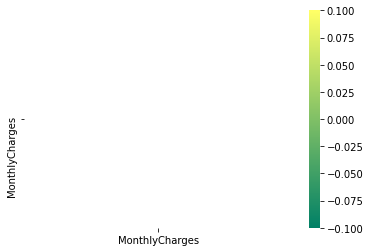

Гистограммы для всех числовых столбцов таблицы


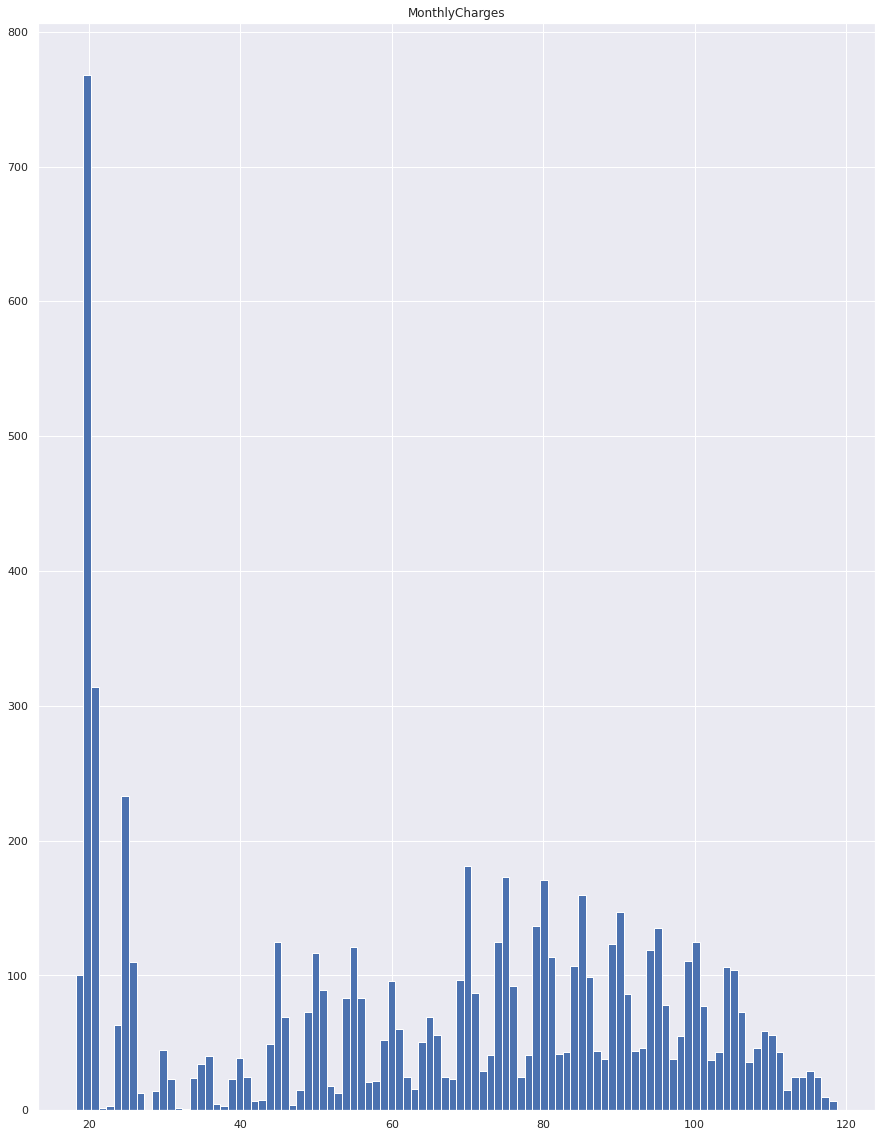

клиент: -----------------------------------------------------------------------------------------------------------------

Вывод первых 10-и строк


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



Вывод основной информации о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Количество пропущенных значений для каждого столбца


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


Процент(доля) пропусков


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64


Проверка уникальных значений столбцов
Уникальные значения в столбце customerID


,customerID
2307,0002-ORFBO
3488,0003-MKNFE
3845,0004-TLHLJ
5931,0011-IGKFF
5569,0013-EXCHZ
...,...
3607,9987-LUTYD
2875,9992-RRAMN
1260,9992-UJOEL
1996,9993-LHIEB


Количество уникальных значений customerID


,value_count
0002-ORFBO,1
0003-MKNFE,1
0004-TLHLJ,1
0011-IGKFF,1
0013-EXCHZ,1
...,...
9987-LUTYD,1
9992-RRAMN,1
9992-UJOEL,1
9993-LHIEB,1




Уникальные значения в столбце gender


,gender
0,Female
1,Male


Количество уникальных значений gender


,value_count
Female,3488
Male,3555




Уникальные значения в столбце SeniorCitizen


,SeniorCitizen
0,0
1,1


Количество уникальных значений SeniorCitizen


,value_count
0,5901
1,1142




Уникальные значения в столбце Partner


,Partner
1,No
0,Yes


Количество уникальных значений Partner


,value_count
No,3641
Yes,3402




Уникальные значения в столбце Dependents


,Dependents
0,No
1,Yes


Количество уникальных значений Dependents


,value_count
No,4933
Yes,2110





Количество строк-дубликатов в данных


0


Корреляция колличественных признаков


,SeniorCitizen
SeniorCitizen,1.0


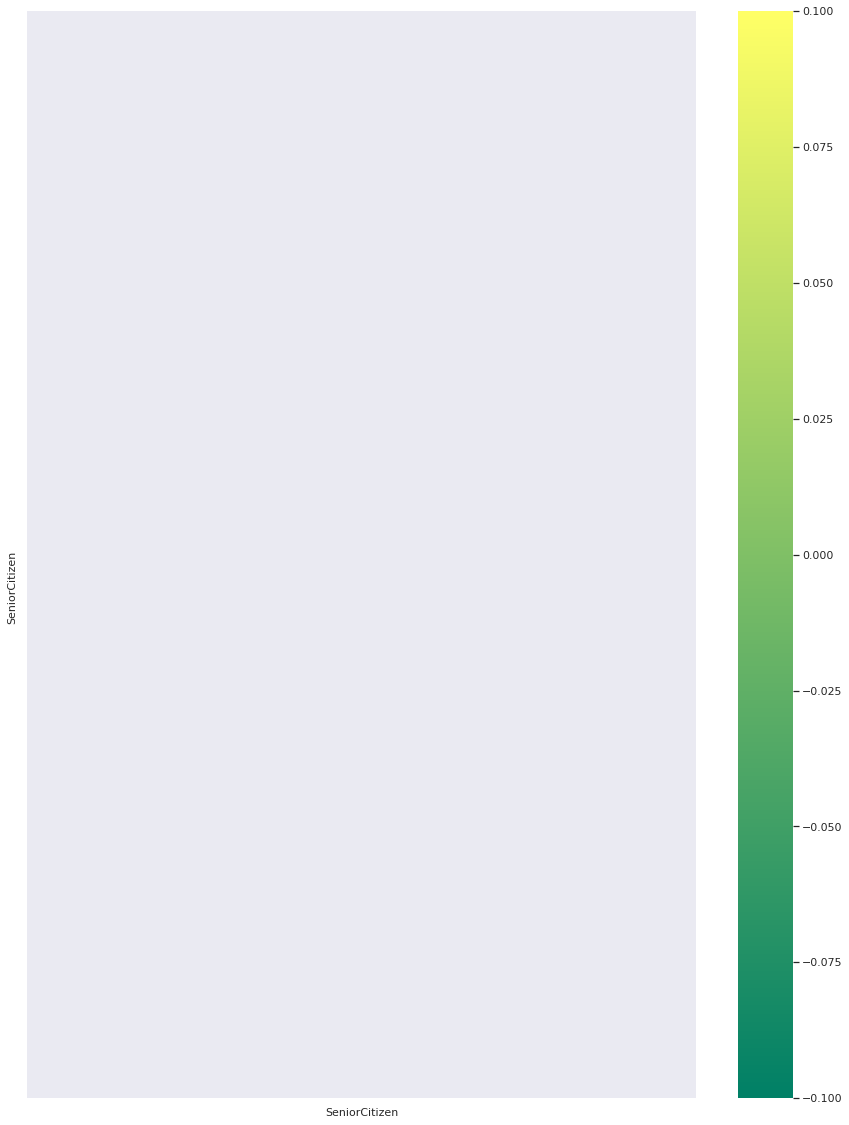

Гистограммы для всех числовых столбцов таблицы


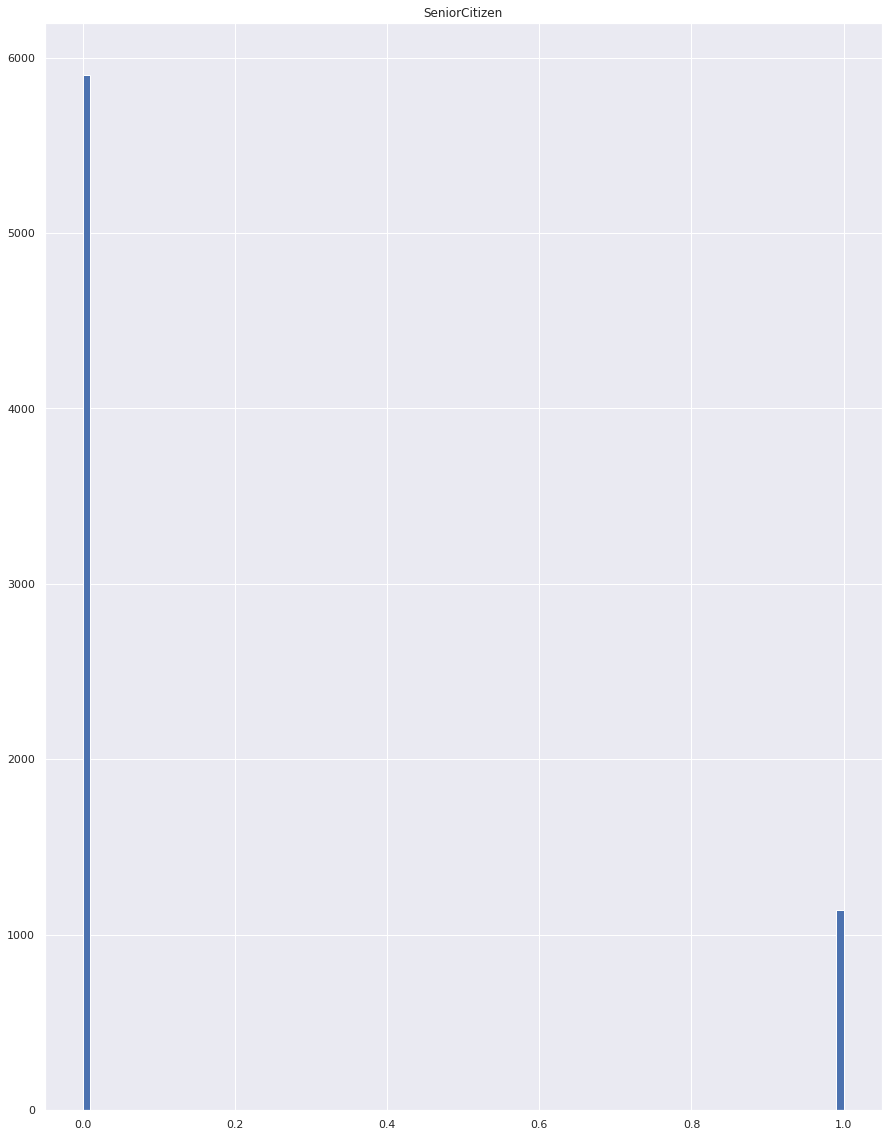

интеренет: -----------------------------------------------------------------------------------------------------------------

Вывод первых 10-и строк


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No



Вывод основной информации о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3533-UVMOM,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Количество пропущенных значений для каждого столбца


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


Процент(доля) пропусков


customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64


Проверка уникальных значений столбцов
Уникальные значения в столбце customerID


,customerID
1820,0002-ORFBO
2727,0003-MKNFE
3008,0004-TLHLJ
4627,0011-IGKFF
4363,0013-EXCHZ
...,...
2823,9987-LUTYD
2251,9992-RRAMN
1007,9992-UJOEL
1570,9993-LHIEB


Количество уникальных значений customerID


,value_count
0002-ORFBO,1
0003-MKNFE,1
0004-TLHLJ,1
0011-IGKFF,1
0013-EXCHZ,1
...,...
9987-LUTYD,1
9992-RRAMN,1
9992-UJOEL,1
9993-LHIEB,1




Уникальные значения в столбце InternetService


,InternetService
0,DSL
1,Fiber optic


Количество уникальных значений InternetService


,value_count
DSL,2421
Fiber optic,3096




Уникальные значения в столбце OnlineSecurity


,OnlineSecurity
0,No
1,Yes


Количество уникальных значений OnlineSecurity


,value_count
No,3498
Yes,2019




Уникальные значения в столбце OnlineBackup


,OnlineBackup
1,No
0,Yes


Количество уникальных значений OnlineBackup


,value_count
No,3088
Yes,2429




Уникальные значения в столбце DeviceProtection


,DeviceProtection
0,No
1,Yes


Количество уникальных значений DeviceProtection


,value_count
No,3095
Yes,2422




Уникальные значения в столбце TechSupport


,TechSupport
0,No
1,Yes


Количество уникальных значений TechSupport


,value_count
No,3473
Yes,2044




Уникальные значения в столбце StreamingTV


,StreamingTV
0,No
1,Yes


Количество уникальных значений StreamingTV


,value_count
No,2810
Yes,2707




Уникальные значения в столбце StreamingMovies


,StreamingMovies
0,No
1,Yes


Количество уникальных значений StreamingMovies


,value_count
No,2785
Yes,2732





Количество строк-дубликатов в данных


0


Корреляция колличественных признаков


""


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
InternetService,1.0,1.000000,0.341950,0.008098,0.000000,0.326553,0.260564,0.246018
OnlineSecurity,1.0,0.341950,1.000000,0.277245,0.263021,0.415484,0.065004,0.084426
OnlineBackup,1.0,0.008098,0.277245,1.000000,0.285491,0.293663,0.227275,0.211500
DeviceProtection,1.0,0.000000,0.263021,0.285491,1.000000,0.360774,0.420014,0.437634
TechSupport,1.0,0.326553,0.415484,0.293663,0.360774,1.000000,0.249535,0.250349
StreamingTV,1.0,0.260564,0.065004,0.227275,0.420014,0.249535,1.000000,0.630406
StreamingMovies,1.0,0.246018,0.084426,0.211500,0.437634,0.250349,0.630406,1.000000


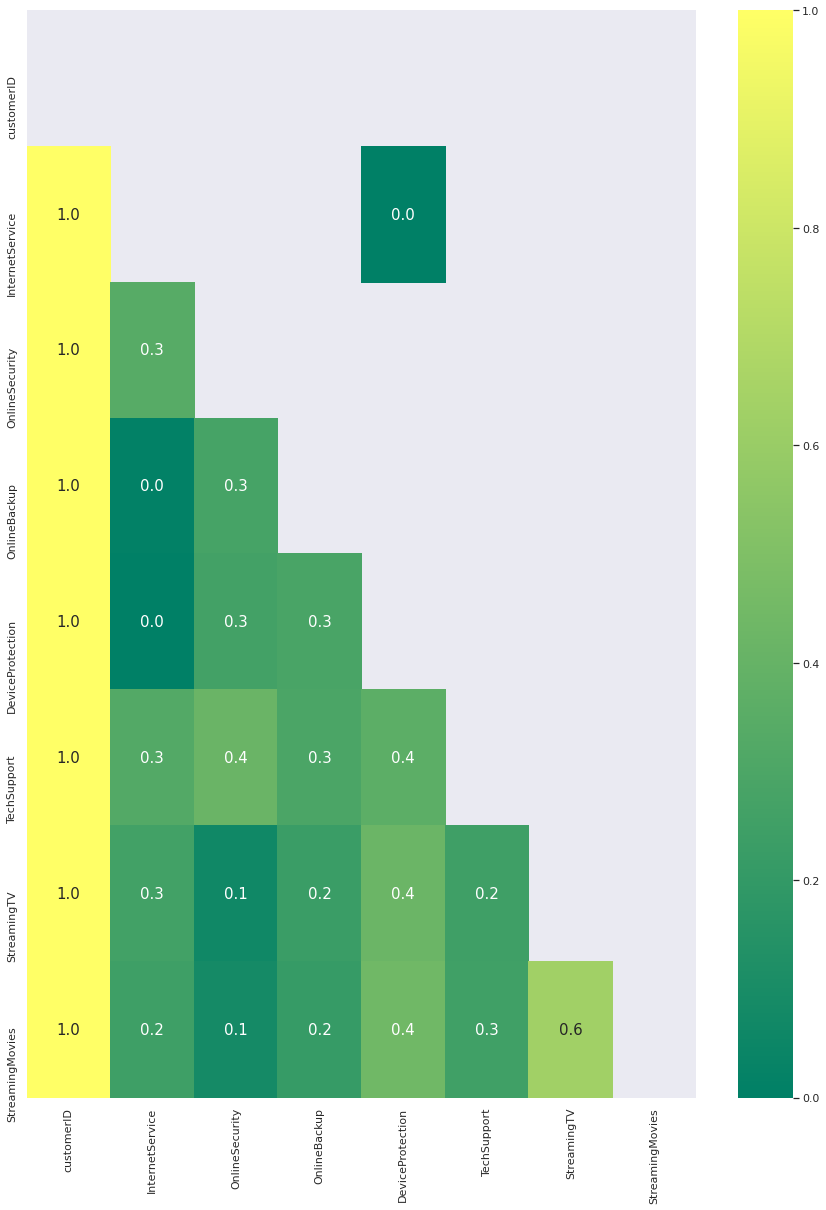


Гистограммы для всех числовых столбцов таблицы


телефон: -----------------------------------------------------------------------------------------------------------------

Вывод первых 10-и строк


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes



Вывод основной информации о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,3533-UVMOM,No
freq,1,3390



Количество пропущенных значений для каждого столбца


customerID       0
MultipleLines    0
dtype: int64


Процент(доля) пропусков


customerID       0.0
MultipleLines    0.0
dtype: float64


Проверка уникальных значений столбцов
Уникальные значения в столбце customerID


,customerID
2112,0002-ORFBO
3173,0003-MKNFE
3501,0004-TLHLJ
5385,0011-IGKFF
5051,0013-EXCHZ
...,...
3300,9986-BONCE
3282,9987-LUTYD
2625,9992-RRAMN
1145,9992-UJOEL


Количество уникальных значений customerID


,value_count
0002-ORFBO,1
0003-MKNFE,1
0004-TLHLJ,1
0011-IGKFF,1
0013-EXCHZ,1
...,...
9986-BONCE,1
9987-LUTYD,1
9992-RRAMN,1
9992-UJOEL,1




Уникальные значения в столбце MultipleLines


,MultipleLines
0,No
1,Yes


Количество уникальных значений MultipleLines


,value_count
No,3390
Yes,2971





Количество строк-дубликатов в данных


0


Корреляция колличественных признаков


""


,customerID,MultipleLines
customerID,1.0,1.0
MultipleLines,1.0,1.0


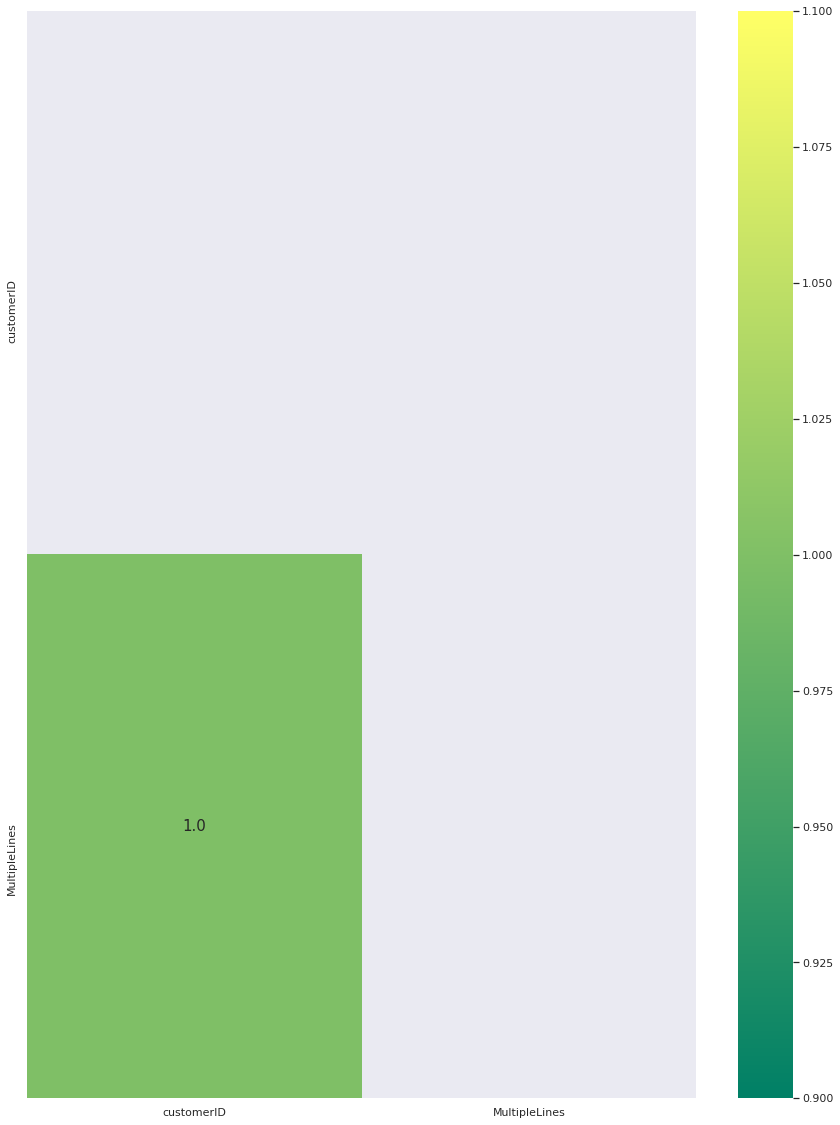


Гистограммы для всех числовых столбцов таблицы




In [3]:
for d,n in zip(df,name):
    
    print(n,'-----------------------------------------------------------------------------------------------------------------')
    print()
    print('Вывод первых 10-и строк')
    display(d.head(10)) # вывод первых 10-и строк
    print()
    print('Вывод основной информации о датафрейме')
    print()
    d.info() # вывод основной информации о датафрейме
    display(d.describe())
    print()
    print('Количество пропущенных значений для каждого столбца')
    display(d.isna().sum()) # количество пропущенных значений для каждого столбца
    print()
    print('Процент(доля) пропусков')
    display(d.isna().mean()*100) # процент(доля) пропусков
    print()
    print('Проверка уникальных значений столбцов')
    # проверка уникальных значений столбцов
    # Получение списка уникальных значений для каждого столбца и их количество
    for col in d.columns:
        unique_values = pd.Series(d[col].unique()).to_frame(name=col).sort_values(by=col, ascending=True)
        unique_value_counts = pd.Series(d[col].value_counts()).to_frame(name='value_count').sort_index(ascending=True)
        print("Уникальные значения в столбце", col)
        display(unique_values)
        print('Количество уникальных значений', col)
        display(unique_value_counts)
        print("\n")
    print()
    print('Количество строк-дубликатов в данных')
    display(d.duplicated().sum()) # количество строк-дубликатов в данных
    print()
    print('Корреляция колличественных признаков')
    #sb.heatmap(d.corr()) plt.show()                            # гистограмма корр. №1
    #sb.heatmap(d.corr(), cmap="YlGnBu", annot=True) plt.show() # гистограмма корр. №2
                                                                # гистограмма корр. №3
    try:
        display(d.corr()) # корреляция колличественных признаков
        sb.heatmap(d.corr(), annot=True, cmap='summer', mask=np.triu(d.corr()), fmt=".1f", annot_kws={'size': 15}) 
        sb.set(rc={'figure.figsize':(15,20)}) # размер графика
        plt.show()
    except Exception:
        pass
        display(d.phik_matrix()) # корреляция текстовых признаков
        sb.heatmap(d.phik_matrix(), annot=True, cmap='summer', mask=np.triu(d.phik_matrix()), fmt=".1f", annot_kws={'size': 15})
        sb.set(rc={'figure.figsize':(15,20)}) # размер графика
        plt.show()
        print()
    print('Гистограммы для всех числовых столбцов таблицы')
    try:
        d.hist(figsize=(15, 20), bins=100); # гистограммы для всех числовых столбцов таблицы
        plt.show()
    except Exception:
        pass 
        print()
        print()

    Данные распознались ______________________________________________________ДА
    Названия столбцов в нижнем регистре ______________________________________НЕТ -------------(исправилю)
    Имеются значения с неправельным типом данных _____________________________ДА --------------(исправилю)
    Пропущеные значения ______________________________________________________НЕТ
    Откланения в уникальных значениях ________________________________________ДА --------------(исправилю)
    Дубликаты ________________________________________________________________НЕТ
    Имеются неважные(нерелевантные) столбцы(признаки) для МО _________________ДА --------------(исправилю)
    Имеются не отмасштабированые значения для МО _____________________________ДА --------------(исправилю)
    Имеются строковые категариальные признаки ________________________________ДА --------------(исправилю)
    Имеются сильно зависимые признаки для МО _________________________________НЕТ
    Отсутствуют целевые столбцы(признаки) для МО _____________________________НЕТ

## Исследование задачи

Сделать визуализацию графиков, исследовать корреляцию признаков. Для числовых признаков используем корреляцию Спирмена, для категориальных - Крамера. Можно применять инструмент фи-корреляции для смешанного набора признаков (библиотека phik)

### Объеденение таблиц в одну

In [21]:
data = pd.merge(контракт, клиент, how='left', on='customerID')
data = pd.merge(data, интеренет, how='left', on='customerID')
data = pd.merge(data, телефон, how='left', on='customerID')
# задам customerID как индекс
data = data.set_index('customerID')

data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Названия столбцов к нижнему регистру

In [22]:
# Функция для замены заглавных букв на прописные и вставки символа подчеркивания перед заглавными буквами кроме 1-ой
def convert_column_names(name):
    new_name = re.sub(r'(?<!^)(?=[A-Z])', '_', name)
    return new_name.lower()

# Применение функции к названиям столбцов
data.columns = [convert_column_names(col) for col in data.columns]

# data.head()

### Создание целевого признака

In [23]:
data['ottok'] = (data['end_date'] != 'No').astype(int)

# data.head()

### Создание столбца с количеством дней обслуживания

In [24]:
data['begin_date'] = pd.to_datetime(data['begin_date'])
data['end_date'] = data['end_date'].where(data['end_date'] != 'No', '2020-02-01')
data['end_date'] = pd.to_datetime(data['end_date'])

data['dney_obslujivanija'] = (data['end_date'] - data['begin_date']).dt.days

# data.head()

### Исправление данных

In [25]:
display(data[data['total_charges'] == ' '])
# удаление строк с пропускоми столбца total_charges
data = data[data['total_charges'] != ' ']

# смена типа данных столбца total_charges
data['total_charges'] = data['total_charges'].astype(float)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,ottok,dney_obslujivanija
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0


    Пропуски образовались пологаю по причине что это новые пользователи судя дате begin_date и end_date и это их 1й и последний платеж а пересчет в признаке total_charges произойдет после 2го платежа, хотя могли доавиться и значения из monthly_charges в любом случае это ошибка програмирования системы

### Повторный анализ данных 

Для выявления новых свойств после изменеиий


Вывод первых 10-и строк


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,ottok,dney_obslujivanija
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,Yes,0,306
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945



Вывод основной информации о датафрейме

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   begin_date          7030 non-null   datetime64[ns]
 1   end_date            7030 non-null   datetime64[ns]
 2   type                7030 non-null   object        
 3   paperless_billing   7030 non-null   object        
 4   payment_method      7030 non-null   object        
 5   monthly_charges     7030 non-null   float64       
 6   total_charges       7030 non-null   float64       
 7   gender              7030 non-null   object        
 8   senior_citizen      7030 non-null   int64         
 9   partner             7030 non-null   object        
 10  dependents          7030 non-null   object        
 11  internet_service    7030 non-null   object        
 12  online_security     7030 non-null   object        
 1

,monthly_charges,total_charges,senior_citizen,ottok,dney_obslujivanija
count,7030.000000,7030.000000,7030.000000,7030.000000,7030.000000
mean,64.797511,2118.053570,0.162447,0.156615,899.901280
std,30.079868,2111.638246,0.368886,0.363463,682.583555
min,18.250000,19.050000,0.000000,0.000000,28.000000
25%,35.612500,439.962500,0.000000,0.000000,276.000000
50%,70.350000,1345.275000,0.000000,0.000000,761.000000
75%,89.850000,3238.892500,0.000000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,1.000000,2314.000000



Количество пропущенных значений для каждого столбца


begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges         0
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_t_v         0
streaming_movies      0
multiple_lines        0
ottok                 0
dney_obslujivanija    0
dtype: int64


Процент(доля) пропусков


begin_date            0.0
end_date              0.0
type                  0.0
paperless_billing     0.0
payment_method        0.0
monthly_charges       0.0
total_charges         0.0
gender                0.0
senior_citizen        0.0
partner               0.0
dependents            0.0
internet_service      0.0
online_security       0.0
online_backup         0.0
device_protection     0.0
tech_support          0.0
streaming_t_v         0.0
streaming_movies      0.0
multiple_lines        0.0
ottok                 0.0
dney_obslujivanija    0.0
dtype: float64


Проверка уникальных значений столбцов
Уникальные значения в столбце begin_date


,begin_date
74,2013-10-01
72,2013-11-01
75,2013-12-01
73,2014-01-01
24,2014-02-01
...,...
4,2019-09-01
2,2019-10-01
19,2019-11-01
26,2019-12-01


Количество уникальных значений begin_date


,value_count
2013-10-01,3
2013-11-01,2
2013-12-01,3
2014-01-01,7
2014-02-01,365
...,...
2019-09-01,237
2019-10-01,237
2019-11-01,237
2019-12-01,220




Уникальные значения в столбце end_date


,end_date
30,2014-06-01
58,2014-09-01
59,2014-10-01
66,2014-11-01
65,2014-12-01
...,...
37,2019-10-01
17,2019-11-01
44,2019-12-01
16,2020-01-01


Количество уникальных значений end_date


,value_count
2014-06-01,1
2014-09-01,2
2014-10-01,1
2014-11-01,1
2014-12-01,2
...,...
2019-10-01,31
2019-11-01,30
2019-12-01,38
2020-01-01,39




Уникальные значения в столбце type


,type
0,Month-to-month
1,One year
2,Two year


Количество уникальных значений type


,value_count
Month-to-month,3874
One year,1472
Two year,1684




Уникальные значения в столбце paperless_billing


,paperless_billing
1,No
0,Yes


Количество уникальных значений paperless_billing


,value_count
No,2863
Yes,4167




Уникальные значения в столбце payment_method


,payment_method
2,Bank transfer (automatic)
3,Credit card (automatic)
0,Electronic check
1,Mailed check


Количество уникальных значений payment_method


,value_count
Bank transfer (automatic),1542
Credit card (automatic),1520
Electronic check,2365
Mailed check,1603




Уникальные значения в столбце monthly_charges


,monthly_charges
1302,18.25
858,18.40
1563,18.55
721,18.70
1396,18.75
...,...
1524,118.20
1440,118.35
1320,118.60
1027,118.65


Количество уникальных значений monthly_charges


,value_count
18.25,1
18.40,1
18.55,1
18.70,2
18.75,1
...,...
118.20,1
118.35,1
118.60,2
118.65,1




Уникальные значения в столбце total_charges


,total_charges
1698,19.05
3020,19.10
578,19.19
1780,19.20
4070,19.30
...,...
535,8957.52
4057,8998.27
2502,9068.36
5310,9218.88


Количество уникальных значений total_charges


,value_count
19.05,1
19.10,2
19.19,1
19.20,3
19.30,1
...,...
8957.52,1
8998.27,1
9068.36,1
9218.88,1




Уникальные значения в столбце gender


,gender
0,Female
1,Male


Количество уникальных значений gender


,value_count
Female,3483
Male,3547




Уникальные значения в столбце senior_citizen


,senior_citizen
0,0
1,1


Количество уникальных значений senior_citizen


,value_count
0,5888
1,1142




Уникальные значения в столбце partner


,partner
1,No
0,Yes


Количество уникальных значений partner


,value_count
No,3638
Yes,3392




Уникальные значения в столбце dependents


,dependents
0,No
1,Yes


Количество уникальных значений dependents


,value_count
No,4932
Yes,2098




Уникальные значения в столбце internet_service


,internet_service
0,DSL
1,Fiber optic


Количество уникальных значений internet_service


,value_count
DSL,3081
Fiber optic,3949




Уникальные значения в столбце online_security


,online_security
0,No
1,Yes


Количество уникальных значений online_security


,value_count
No,4405
Yes,2625




Уникальные значения в столбце online_backup


,online_backup
1,No
0,Yes


Количество уникальных значений online_backup


,value_count
No,3957
Yes,3073




Уникальные значения в столбце device_protection


,device_protection
0,No
1,Yes


Количество уникальных значений device_protection


,value_count
No,3923
Yes,3107




Уникальные значения в столбце tech_support


,tech_support
0,No
1,Yes


Количество уникальных значений tech_support


,value_count
No,4378
Yes,2652




Уникальные значения в столбце streaming_t_v


,streaming_t_v
0,No
1,Yes


Количество уникальных значений streaming_t_v


,value_count
No,3594
Yes,3436




Уникальные значения в столбце streaming_movies


,streaming_movies
0,No
1,Yes


Количество уникальных значений streaming_movies


,value_count
No,3541
Yes,3489




Уникальные значения в столбце multiple_lines


,multiple_lines
0,No
1,Yes


Количество уникальных значений multiple_lines


,value_count
No,3757
Yes,3273




Уникальные значения в столбце ottok


,ottok
0,0
1,1


Количество уникальных значений ottok


,value_count
0,5929
1,1101




Уникальные значения в столбце dney_obslujivanija


,dney_obslujivanija
190,28
217,30
0,31
107,59
108,61
...,...
17,2163
23,2191
248,2253
146,2283


Количество уникальных значений dney_obslujivanija


,value_count
28,1
30,1
31,235
59,3
61,5
...,...
2163,115
2191,264
2253,1
2283,2





Количество строк-дубликатов в данных


0


Корреляция колличественных признаков
корреляция смешанных текстовых и числовых признаков
interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'ottok', 'dney_obslujivanija']


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,ottok,dney_obslujivanija
begin_date,1.000000,0.549738,0.765132,0.077474,0.467124,0.420934,0.773624,0.016512,0.049043,0.485164,0.200594,0.097760,0.369113,0.415382,0.425841,0.367289,0.328911,0.345234,0.436632,0.462035,0.978235
end_date,0.549738,1.000000,0.286750,0.062464,0.168845,0.173202,0.215705,0.018486,0.090085,0.178260,0.056869,0.055753,0.088369,0.160784,0.148333,0.093125,0.122297,0.132531,0.207725,1.000000,0.399124
type,0.765132,0.286750,1.000000,0.106386,0.277443,0.388370,0.470384,0.000000,0.085798,0.179149,0.145938,0.088049,0.192551,0.141162,0.185487,0.215442,0.124331,0.128377,0.066903,0.094652,0.635454
paperless_billing,0.077474,0.062464,0.106386,1.000000,0.368698,0.467227,0.201724,0.000000,0.241722,0.011394,0.171165,0.263615,0.170638,0.004416,0.023897,0.096064,0.132796,0.121445,0.244291,0.082766,0.018497
payment_method,0.467124,0.168845,0.277443,0.368698,1.000000,0.398565,0.334333,0.000000,0.291884,0.244296,0.222763,0.322757,0.315221,0.214279,0.249668,0.318054,0.171342,0.162661,0.341134,0.214303,0.347978
monthly_charges,0.420934,0.173202,0.388370,0.467227,0.398565,1.000000,0.710665,0.008598,0.304557,0.204154,0.182567,0.871519,0.303185,0.361461,0.422259,0.339196,0.643473,0.636311,0.562895,0.225965,0.386804
total_charges,0.773624,0.215705,0.470384,0.201724,0.334333,0.710665,1.000000,0.000000,0.136849,0.382754,0.085058,0.254211,0.316960,0.424472,0.432639,0.345379,0.430867,0.425515,0.538334,0.303641,0.847469
gender,0.016512,0.018486,0.000000,0.000000,0.000000,0.008598,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009242,0.000000
senior_citizen,0.049043,0.090085,0.085798,0.241722,0.291884,0.304557,0.136849,0.000000,1.000000,0.018088,0.323617,0.267119,0.150967,0.000000,0.017864,0.189545,0.038495,0.061036,0.212293,0.085626,0.065056
partner,0.485164,0.178260,0.179149,0.011394,0.244296,0.204154,0.382754,0.000000,0.018088,1.000000,0.651443,0.000000,0.199261,0.205721,0.230696,0.169665,0.196976,0.190257,0.212943,0.227641,0.449874


interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'ottok', 'dney_obslujivanija']
interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'ottok', 'dney_obslujivanija']


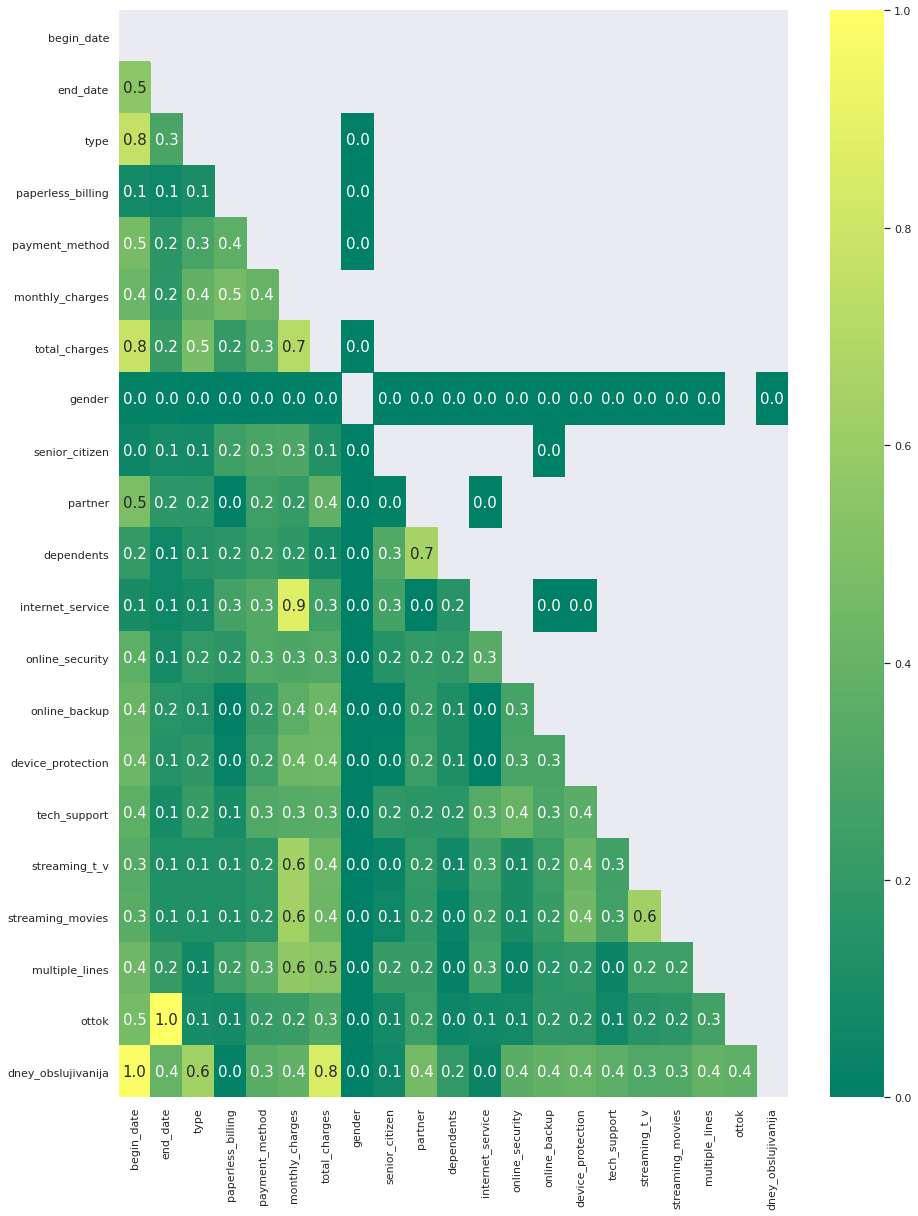


Гистограммы для всех числовых столбцов таблицы


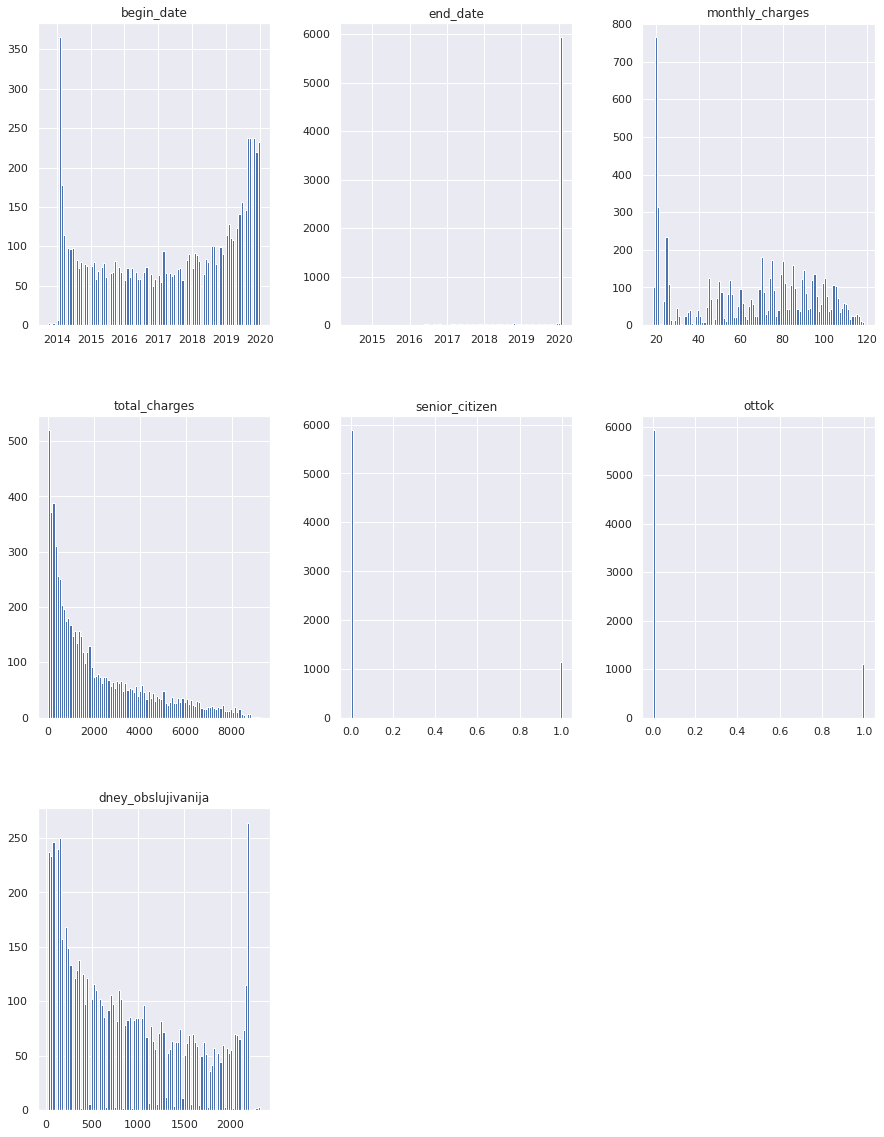

In [28]:
# for d,n in zip(df,name):
d = data
    
# print(n,'-----------------------------------------------------------------------------------------------------------------')
print()
print('Вывод первых 10-и строк')
display(d.head(10)) # вывод первых 10-и строк
print()
print('Вывод основной информации о датафрейме')
print()
d.info() # вывод основной информации о датафрейме
display(d.describe())
print()
print('Количество пропущенных значений для каждого столбца')
display(d.isna().sum()) # количество пропущенных значений для каждого столбца
print()
print('Процент(доля) пропусков')
display(d.isna().mean()*100) # процент(доля) пропусков
print()
print('Проверка уникальных значений столбцов')
# проверка уникальных значений столбцов
# Получение списка уникальных значений для каждого столбца и их количество
for col in d.columns:
    unique_values = pd.Series(d[col].unique()).to_frame(name=col).sort_values(by=col, ascending=True)
    unique_value_counts = pd.Series(d[col].value_counts()).to_frame(name='value_count').sort_index(ascending=True)
    print("Уникальные значения в столбце", col)
    display(unique_values)
    print('Количество уникальных значений', col)
    display(unique_value_counts)
    print("\n")
print()
print('Количество строк-дубликатов в данных')
display(d.duplicated().sum()) # количество строк-дубликатов в данных
print()
print('Корреляция колличественных признаков')
#sb.heatmap(d.corr()) plt.show()                            # гистограмма корр. №1
#sb.heatmap(d.corr(), cmap="YlGnBu", annot=True) plt.show() # гистограмма корр. №2
                                                            # гистограмма корр. №3
#try:
#    display(d.corr()) # корреляция колличественных признаков
#    sb.heatmap(d.corr(), annot=True, cmap='summer', mask=np.triu(d.corr()), fmt=".1f", annot_kws={'size': 15}) 
#    sb.set(rc={'figure.figsize':(15,20)}) # размер графика
#    plt.show()
#except Exception:
#    pass
#    display(d.phik_matrix()) # корреляция смешанных текстовых и числовых признаков
#    sb.heatmap(d.phik_matrix(), annot=True, cmap='summer', mask=np.triu(d.phik_matrix()), fmt=".1f", annot_kws={'size': 15})
#    sb.set(rc={'figure.figsize':(15,20)}) # размер графика
#    plt.show()
#    print()
                                                            # гистограмма корр. №4
print('корреляция смешанных текстовых и числовых признаков')        
display(d.phik_matrix()) # корреляция смешанных текстовых и числовых признаков
sb.set(rc={'figure.figsize':(15,20)}) # размер графика
sb.heatmap(d.phik_matrix(), annot=True, cmap='summer', mask=np.triu(d.phik_matrix()), fmt=".1f", annot_kws={'size': 15})
plt.show()
print()
print('Гистограммы для всех числовых столбцов таблицы')
try:
    d.hist(figsize=(15, 20), bins=100); # гистограммы для всех числовых столбцов таблицы
    plt.show()
except Exception:
    pass 
    print()
    print()

### Исправление данных продолжение

In [29]:
# заполнение пропусков
data = data.ffill(axis=0)
data = data.bfill(axis=0)
display(data.isna().sum())
print('-'*50)
# удаление дубликатов
data = data.drop_duplicates()
display(data.duplicated().sum())

begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges         0
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_t_v         0
streaming_movies      0
multiple_lines        0
ottok                 0
dney_obslujivanija    0
dtype: int64

--------------------------------------------------


0

    Названия столбцов в нижнем регистре ______________________________________НЕТ -------------(исправил)
    Имеются значения с неправельным типом данных _____________________________ДА --------------(исправил)
    Пропущеные значения ______________________________________________________ДА --------------(исправил)
    Откланения в уникальных значениях ________________________________________ДА --------------(исправил)
    Дубликаты ________________________________________________________________ДА --------------(исправил)
    Имеются неважные(нерелевантные) столбцы(признаки) для МО _________________ДА --------------(исправилю)
    Имеются не отмасштабированые значения для МО _____________________________ДА --------------(исправилю)
    Имеются строковые категариальные признаки ________________________________ДА --------------(исправилю)
    Имеются сильно зависимые признаки для МО _________________________________ДА --------------(исправилю)
    Отсутствуют целевые столбцы(признаки) для МО _____________________________НЕТ

### Сравнить группы клиентов ушедших и оставшихся

In [17]:
def plot_churn_histogram(data, column, bins=50):
    plt.figure(figsize=(15, 7))
    plt.hist(data[data['ottok'] == 0][column], bins=bins, alpha=0.5, label='Не отток')
    plt.hist(data[data['ottok'] == 1][column], bins=bins, alpha=0.5, label='Отток')
    plt.xlabel(column, size=15)
    plt.ylabel('Частота', size=15)
    plt.title(f'Гистограмма оттока в зависимости от {column}', size=25)
    plt.legend()
    plt.show()

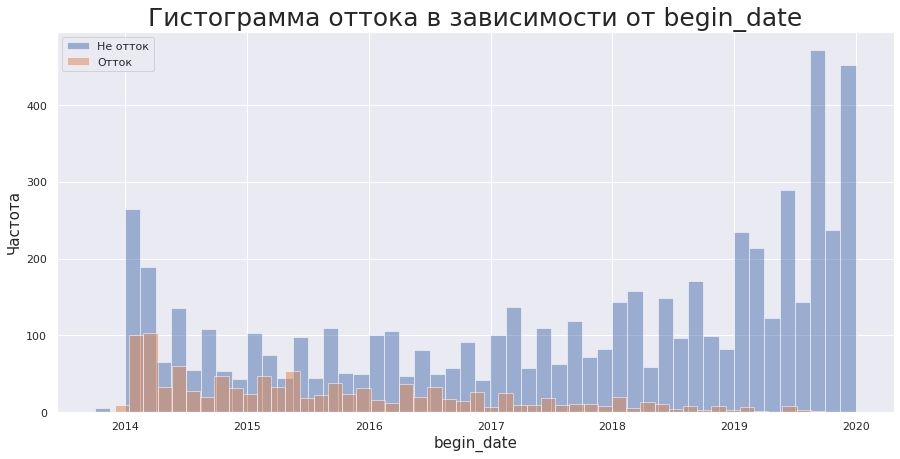

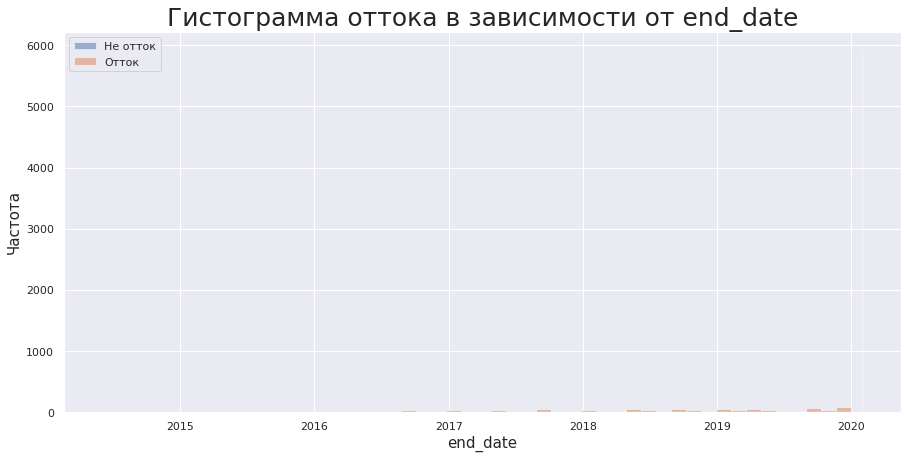

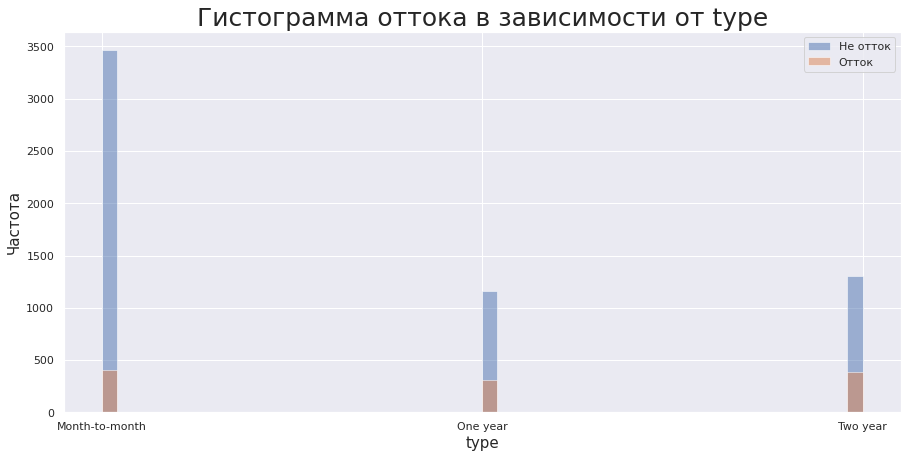

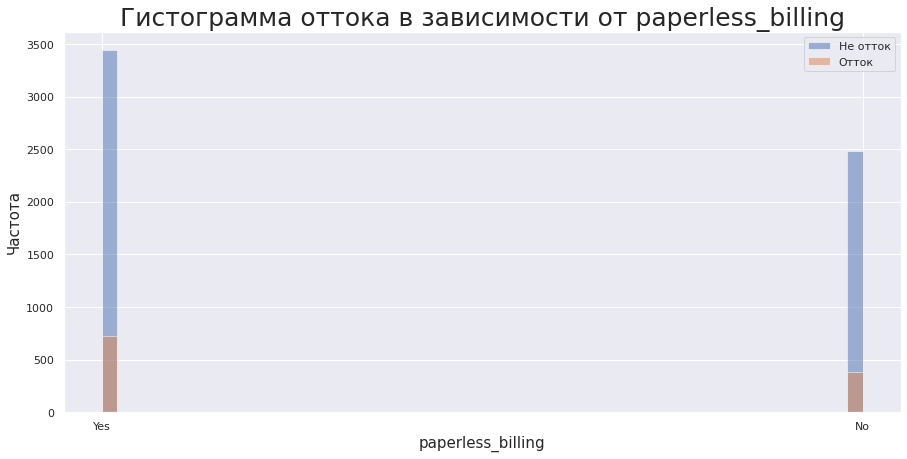

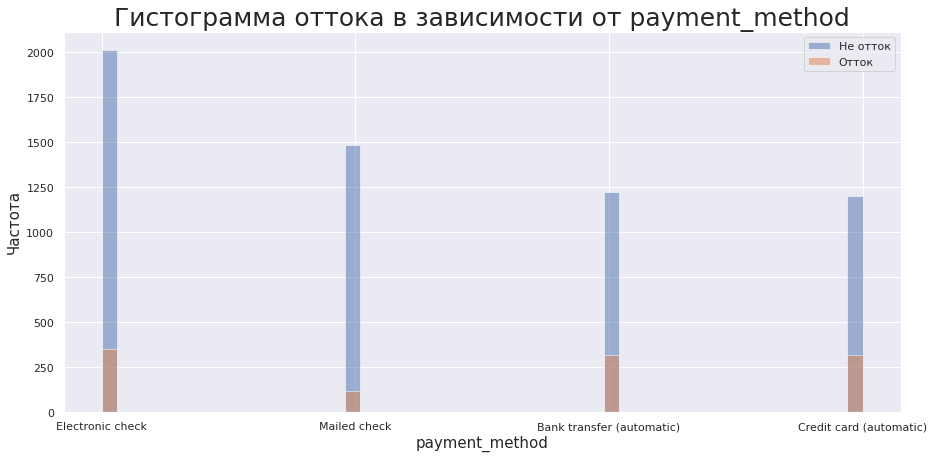

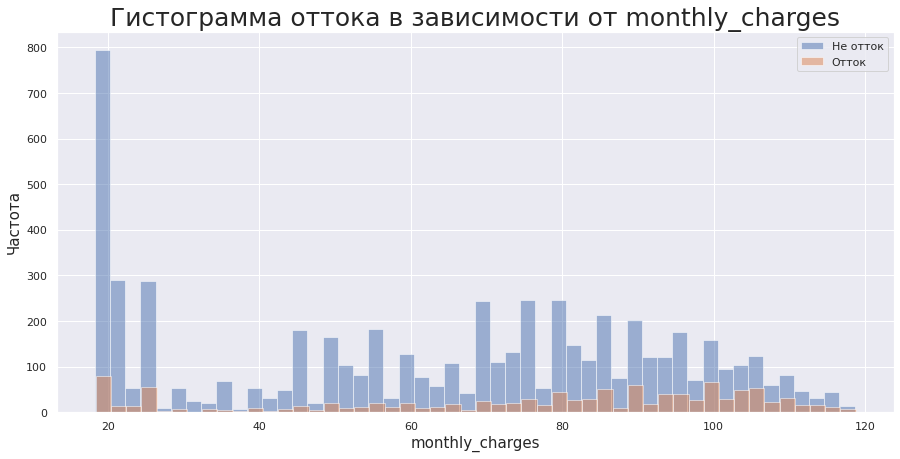

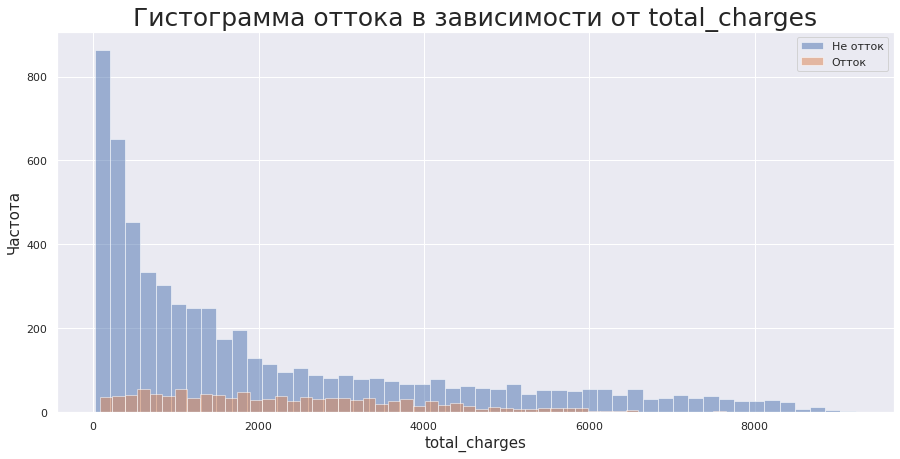

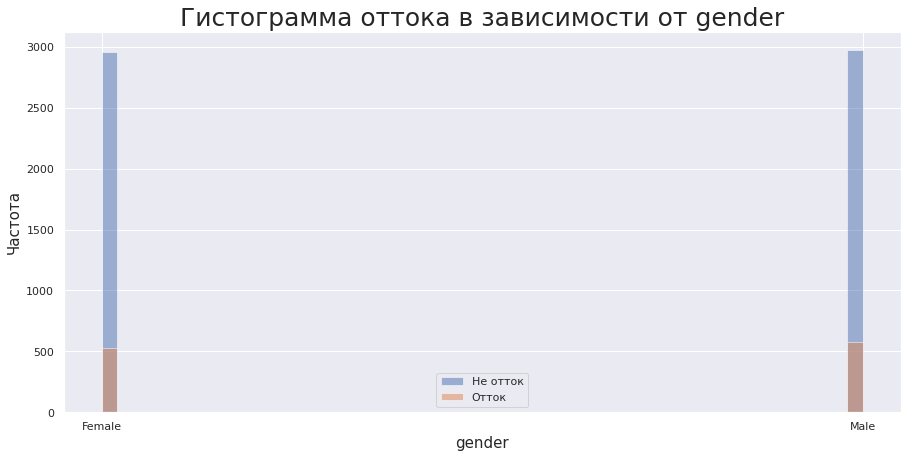

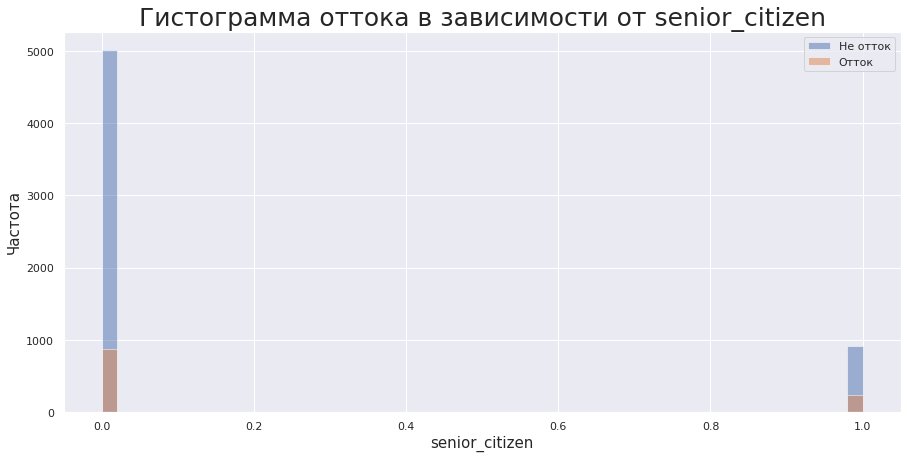

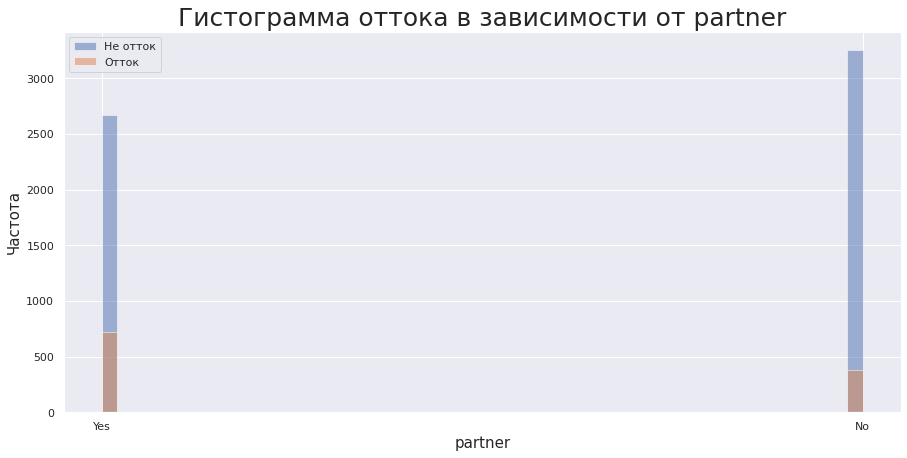

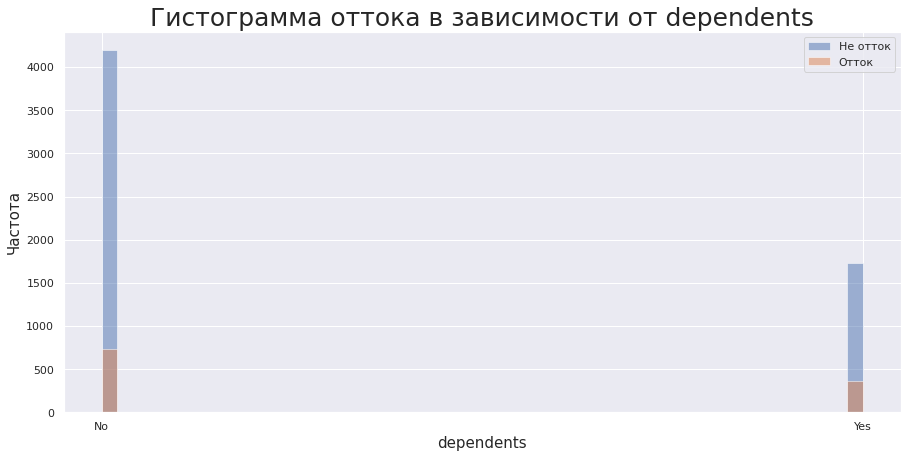

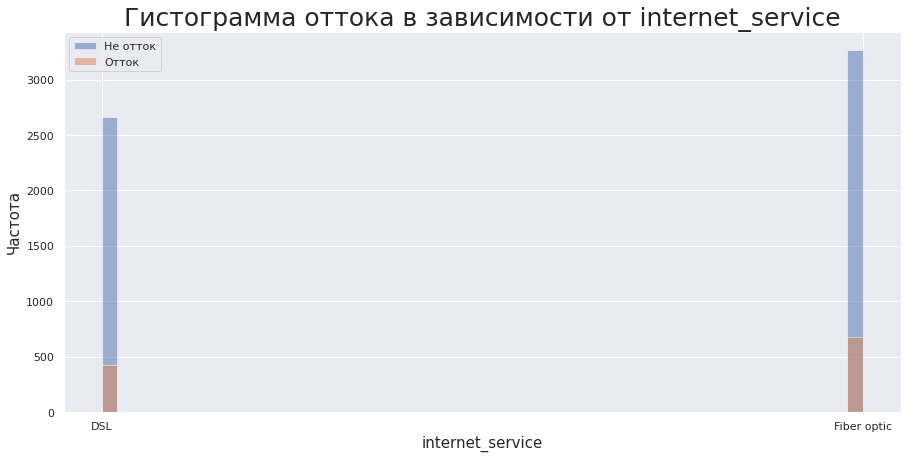

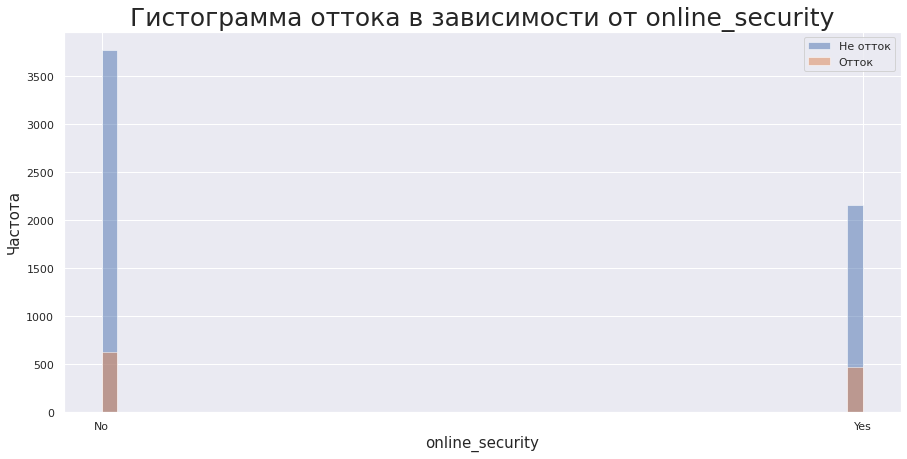

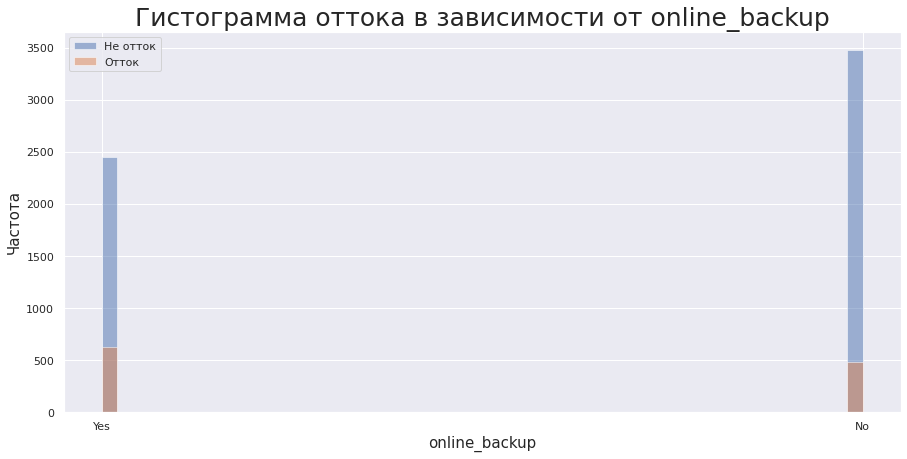

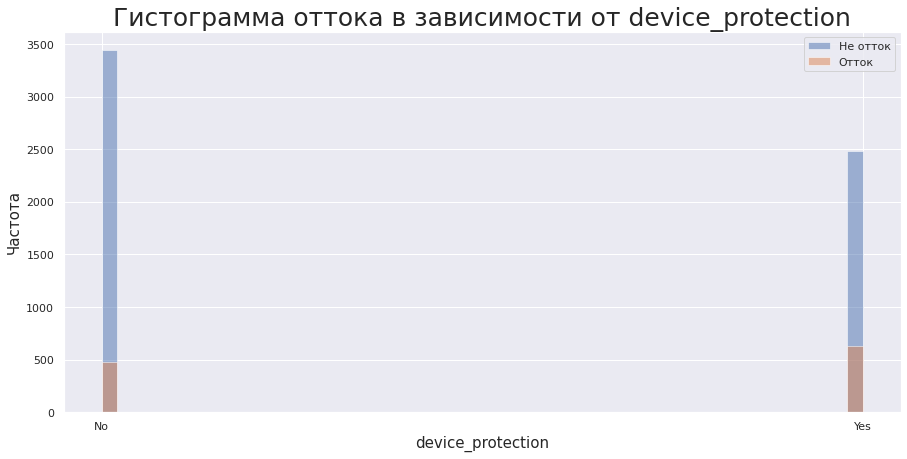

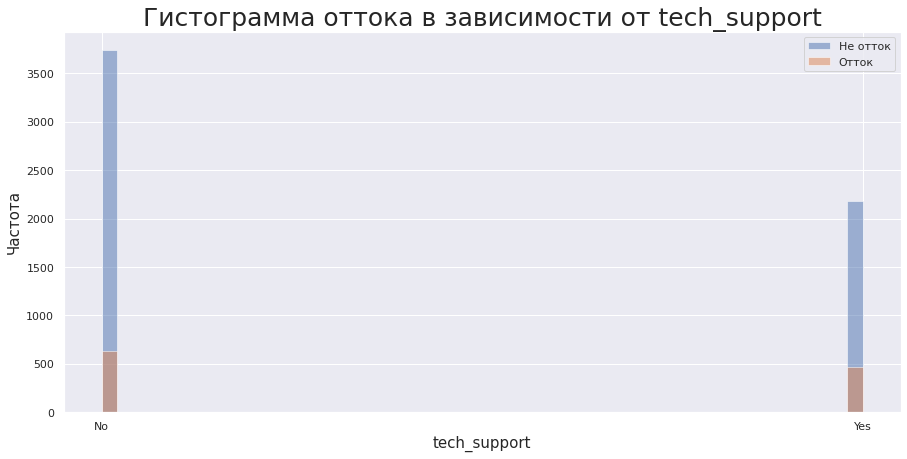

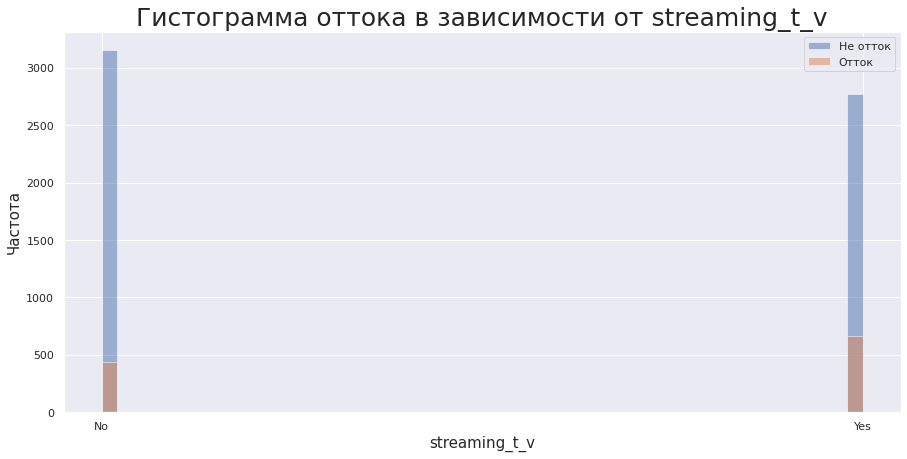

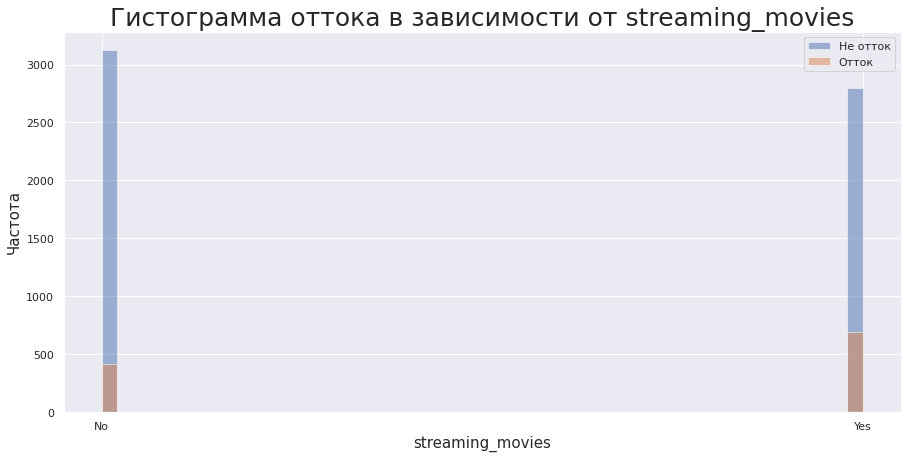

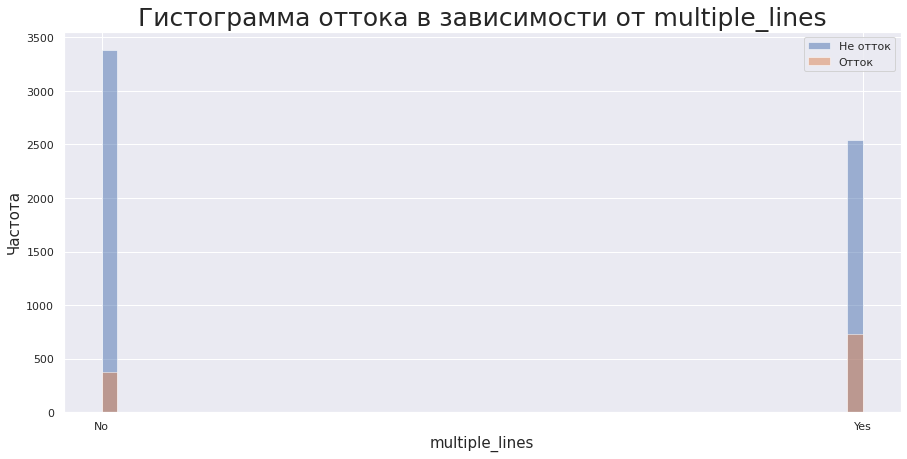

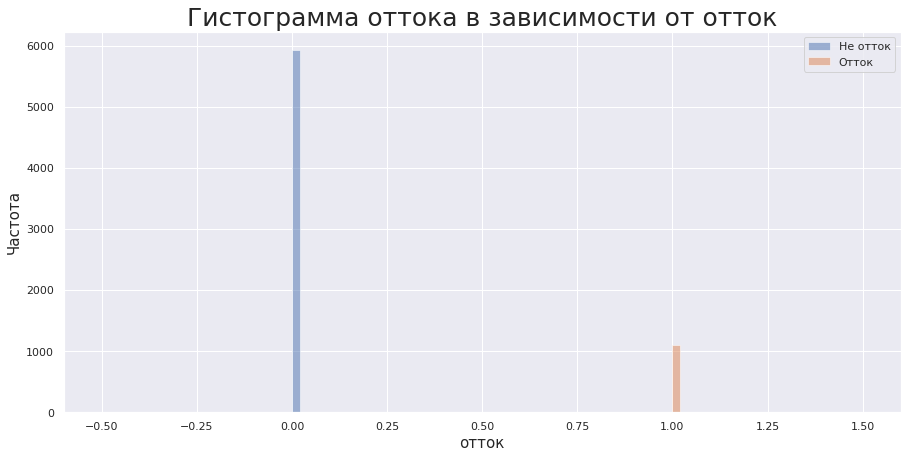

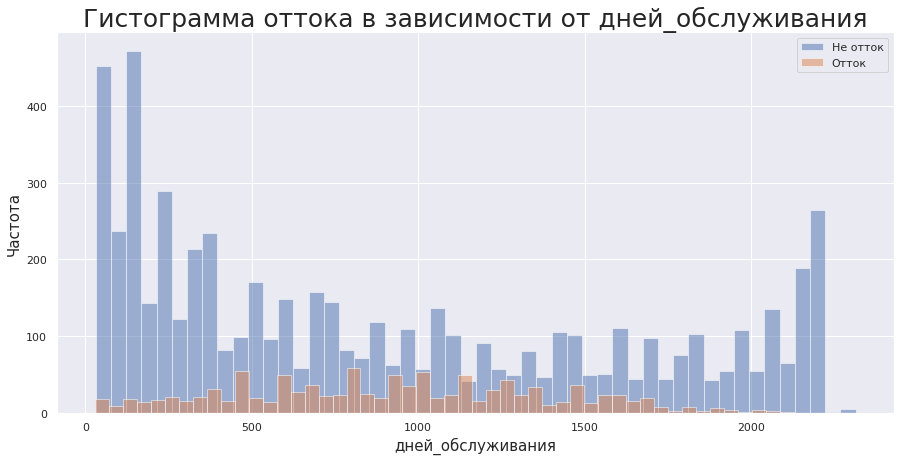

In [18]:
columns = data.columns

for column in columns:
    plot_churn_histogram(data, column)

    Отток в зависимости от даты начала договора был высоким лишь в начале постепенно снижаясь, с 2017 года отток почти иссяк и начался заметный рост тех кто оставался
    
    Отток в зависимости от суммы ежемесячного платежа в группе дешевых тарифов не высок по отношению к оставшимся, среди средних тарифов минимален а среди дорогих не значителен по отношению к оставшимся но заметен, начиная со 100 уходит приблезительно половина от оставшихся сравниваясь к 120
    
    Отток в зависимости от общей суммы платежей к оставшимся не значителен до 2 тыс. после идет устойчивый отток и постепенное снижение оставшихся, с 4 тыс. снижается отток до минимальных значений стабилизируются оставшиеся до 6 тыс. после отток на уровне погрешности а оставшиеся медленно снижаются к 9 тыс.
    
    Отток от наличия супруга на половину больше чем от одиночек так же и осавшихся чуть меньше среди пар. Наверное связан с кономией среди пар
    
    Отток в зависимости от срока обслуживания по началу и мало к оставшимся с 500 дней начинается рост оттока и падение оставшихся после 1000 дней переодически сравниваются а иногда отток превышает оставшихся к 1500 дней идет восстановление а после падение оттока к 2000 дней до минимума и большой рост оставшихся после

### Сравнить распределение ежемесячных платежей

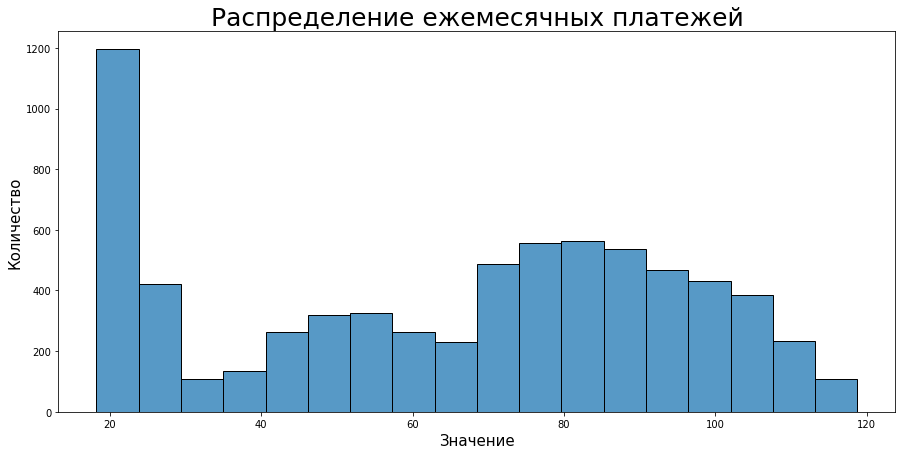

In [10]:
plt.figure(figsize=(15, 7))
sb.histplot(data=data, x='monthly_charges', multiple='stack')
plt.xlabel('Значение', size =15)
plt.ylabel('Количество', size =15)
plt.title('Распределение ежемесячных платежей', size =25)
plt.show()

    Распределение ежемесячных платежей не равномерное но явно выделяется дешевые самый многочисленные, средней стоимости  и дорогие тарифы

### Сравнить самые зависимые признаки

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'отток', 'дней_обслуживания']


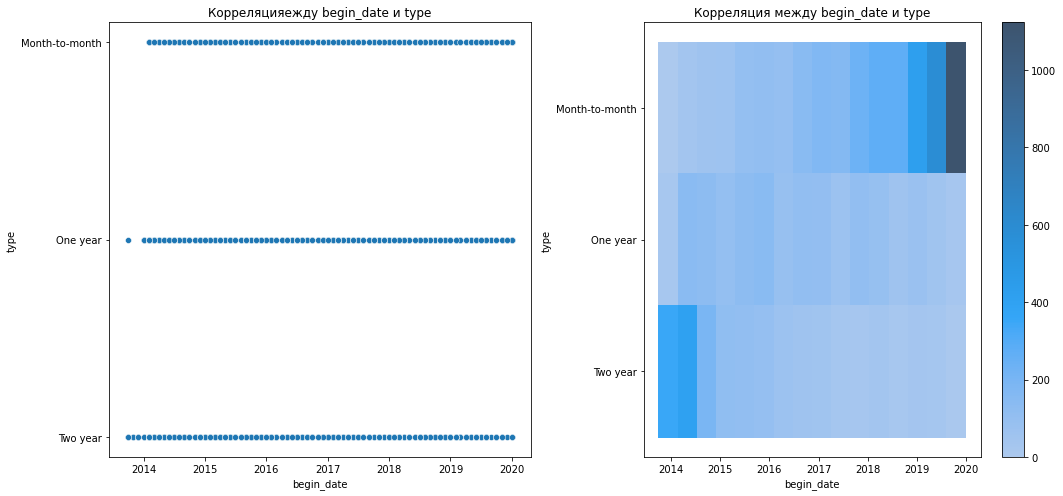

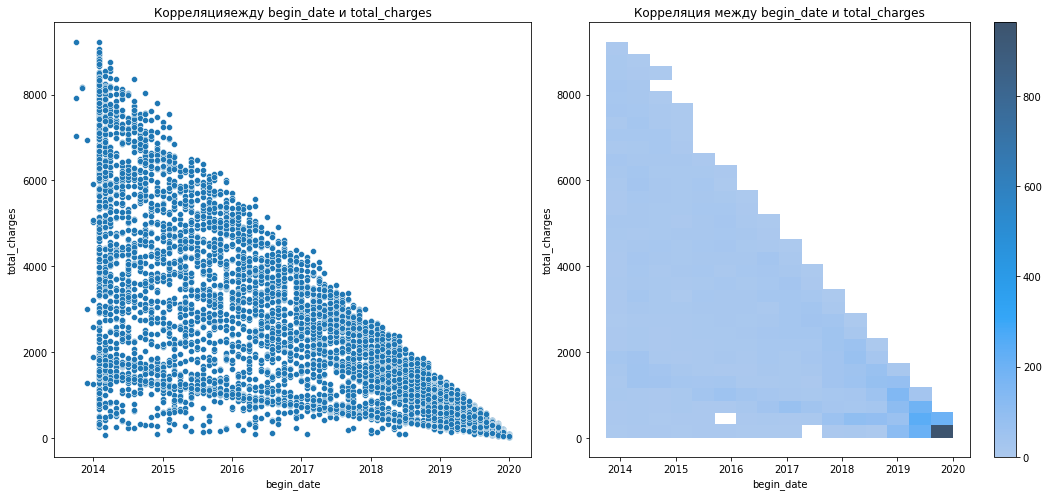

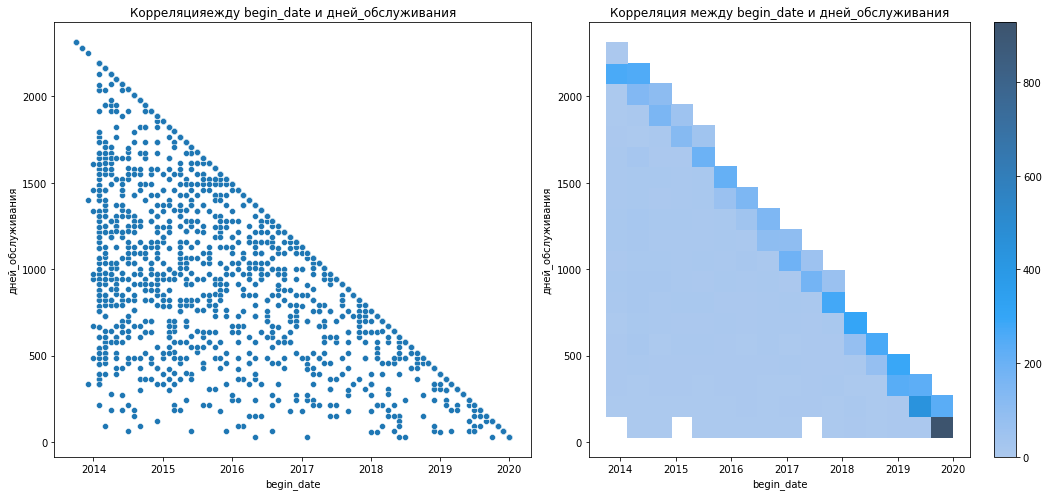

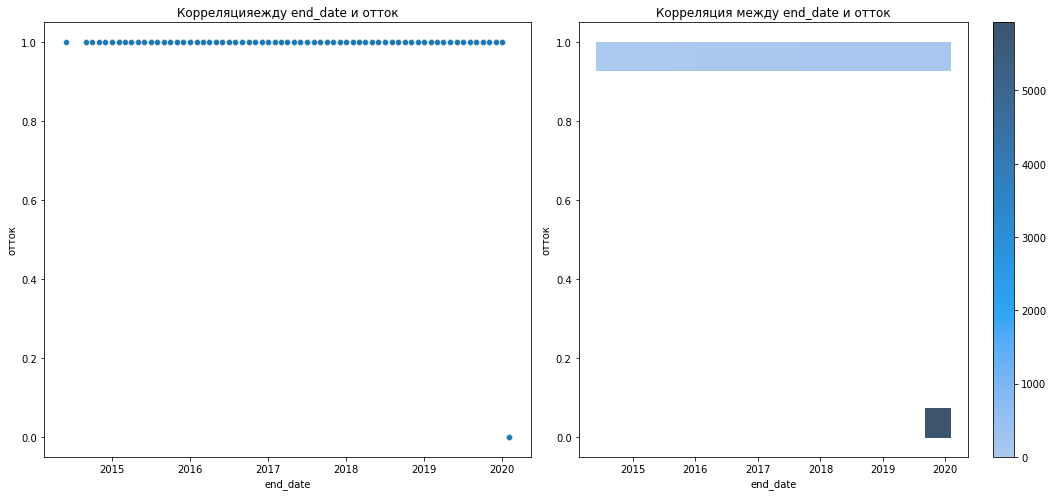

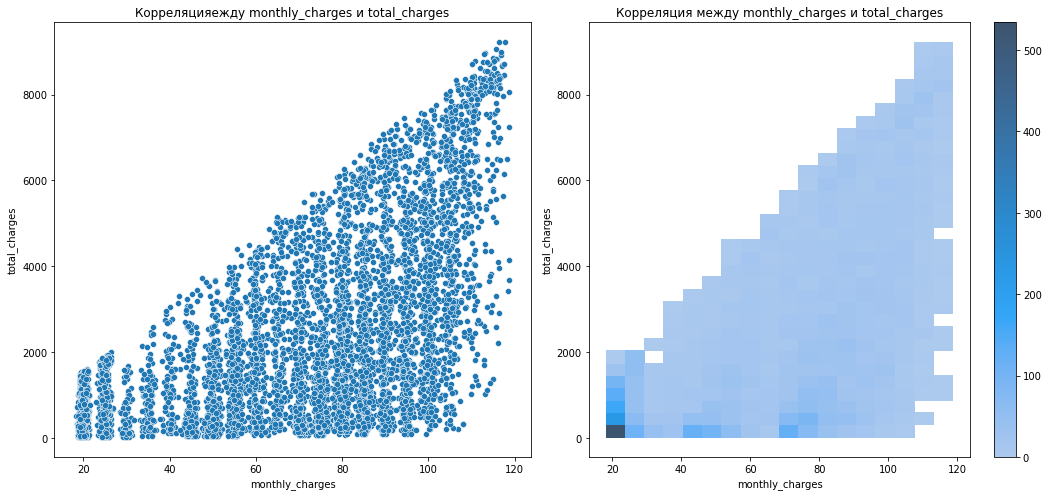

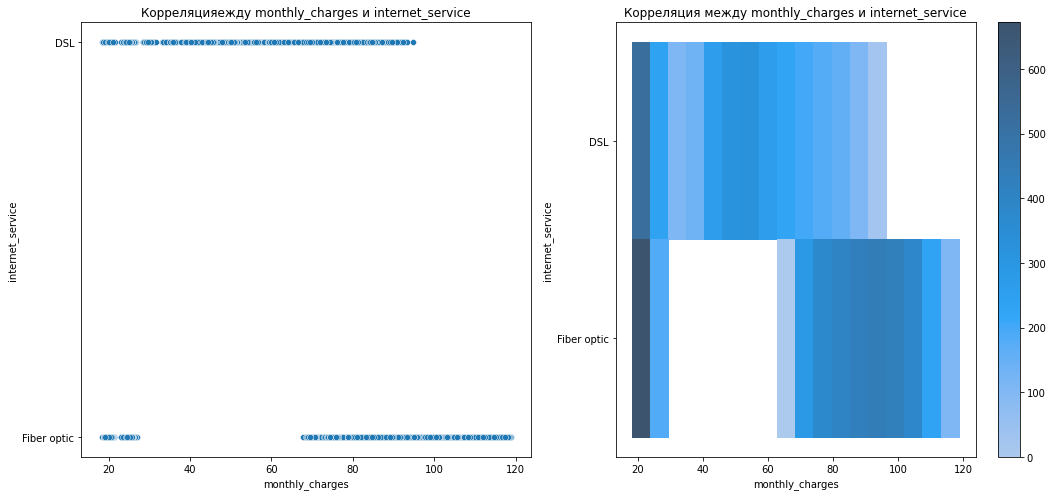

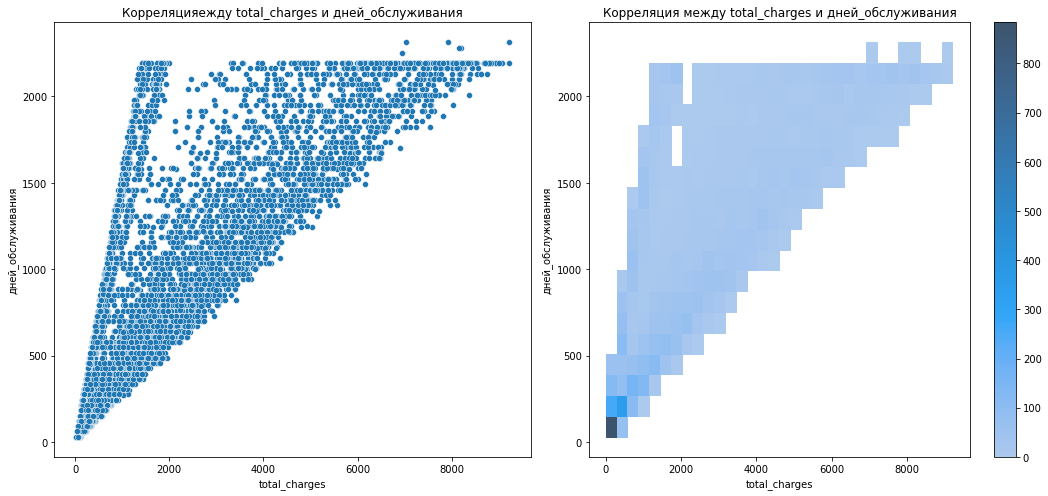

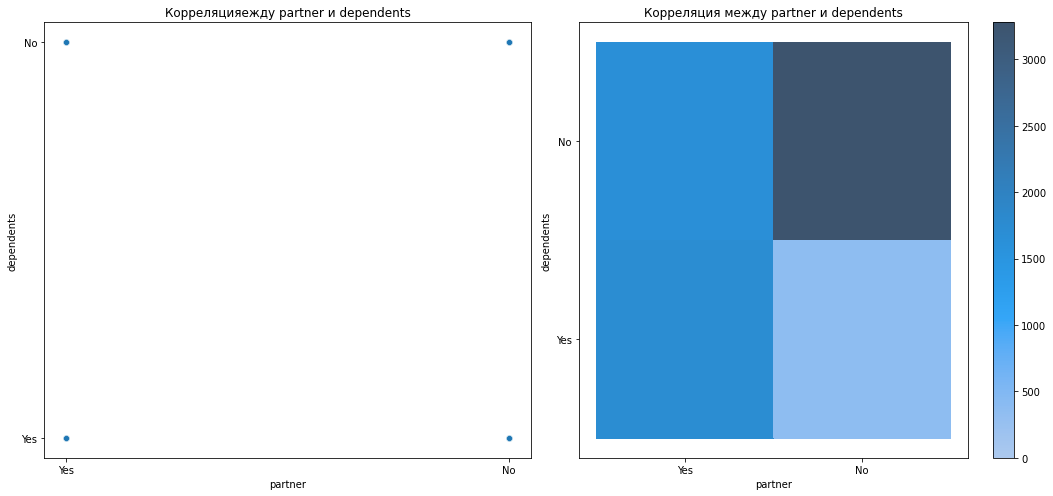

In [215]:
corr_matrix = data.phik_matrix()
strongest_correlations = (corr_matrix.abs() >= 0.65)# & (corr_matrix < 1)

# Перебираем каждую пару переменных
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if strongest_correlations.iloc[i, j]:
            x_var = corr_matrix.columns[i]
            y_var = corr_matrix.columns[j]
            
            plt.figure(figsize=(15, 7))
            plt.subplot(1, 2, 1)
            sb.scatterplot(data=data, x=x_var, y=y_var)
            plt.xlabel(x_var)
            plt.ylabel(y_var)
            plt.title(f'Корреляцияежду {x_var} и {y_var}')
            
            plt.subplot(1, 2, 2)
            sb.histplot(data=data, x=x_var, y=y_var, bins='auto', cbar=True)
            plt.xlabel(x_var)
            plt.ylabel(y_var)
            plt.title(f'Корреляция между {x_var} и {y_var}')
            
            plt.tight_layout()
            plt.show()

    Зависимость начала договора к типу платежа показывает что с 2013 года пользователи массово предпочитали оплачивать услуги за 2 года, за 1 год реже такие же показатели и у типа раз в месяц, но затем по истечении этих 2х лет с 2015 ситуация начинает менятся к 2020му за 2 года почти перестают платить как и за 1 год а за раз в месяц всё больше. Предпологаю так связано с условием подключения и началу работы данного оператора.
    
    Зависимость начала договора к общей суммой платежей показывает что только с 2019 года начинается сильный прирост пользователей и снижение оттока.
    
    Зависимость начала договора к сроку обслуживания показывает что только со 2й половины 2019 года сильный прирост новых пользователей.
    
    Зависимость общей суммы платежей к ежемесячной показывает высокое значение дешовых тарифов и резкое снижение к дорогим.
    
    Зависимость ежемесячной суммы платежей к типу провода высокое значение дешовых тарифов к обоим типам но оптика в приоритете, среди средних тарифов для оптики таких нет для ДСЛ есть а для дорогих наоборот.
    
    Зависимость общей суммы платежей к сроку обслуживания показывает резкий прирост новых пользователей.
    
    Зависимость семейных к иждевенцам показывает большое значение среди одиноких без иждевенцев, почти равное среднее значение среди семейных с иждевенцом и без, и минимальное среди одиноких с иждевенцом.

## Подготовка данных для МО

    размер тестовой выборки: test_size = 0.25 (строго!!!)
    рекомендуется использовать OneHotEncoder для кодирования категориальных признаков. Кодируем после разделения на train и test, чтобы не было утечки в данных;
    баланс классов: Upsampling/Downsampling использовать не нужно (!!!), лучше используйте балансировку классов внутри модели; class_weight = 'balanced'

### Разделение на выборки

In [30]:
target = data['ottok'] # извлечение целевого признака
features = data.drop(['ottok', 'begin_date', 'end_date'] , axis=1) # извлечение признаков а так же удаление некоторых
                                                                   # в целях избежания утечки данных

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=target) # отделение % данных для тестовой выборки от тренеровачной 

print('Извлечение признаков')
print("features      ", features.shape)
print("target        ", target.shape)
print()
print('Отделение " test_size% " данных для тестовой выборки от тренеровачной')
print("features_train", features_train.shape)
print("target_train  ", target_train.shape)
print("features_test ", features_test.shape)
print("target_test   ", target_test.shape)
print()
train_percentage = len(features_train) / len(features) * 100
test_percentage = len(features_test) / len(features) * 100
print('Процентное соотношение получившихся выборок')
print("Тренировочная выборка: {:.2f}%".format(train_percentage))
print("Тестовая выборка:      {:.2f}%".format(test_percentage))


Извлечение признаков
features       (7030, 18)
target         (7030,)

Отделение " test_size% " данных для тестовой выборки от тренеровачной
features_train (5272, 18)
target_train   (5272,)
features_test  (1758, 18)
target_test    (1758,)

Процентное соотношение получившихся выборок
Тренировочная выборка: 74.99%
Тестовая выборка:      25.01%


### Избавление от строковых категариальных признаков

In [31]:
# избавляемся от категориальных(dtype=object) признаков методом OHE

# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
#features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns)  & set(features_test_ohe.columns)
                                                # & set(features_valid_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
#features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

display(features_train_ohe)
features_train_ohe.info()

#display(features_valid_ohe)
#features_valid_ohe.info()

display(features_test_ohe)
features_test_ohe.info()

,payment_method_Credit card (automatic),total_charges,monthly_charges,payment_method_Mailed check,multiple_lines_Yes,internet_service_Fiber optic,type_One year,payment_method_Electronic check,paperless_billing_Yes,online_security_Yes,streaming_movies_Yes,senior_citizen,streaming_t_v_Yes,gender_Male,dependents_Yes,tech_support_Yes,partner_Yes,dney_obslujivanija,device_protection_Yes,online_backup_Yes,type_Two year
customerID,,,,,,,,,,,,,,,,,,,,,
1195-OIYEJ,0,1366.50,91.10,0,0,1,0,1,1,0,1,0,1,1,0,0,0,457,0,0,0
1985-MBRYP,0,844.95,19.65,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1310,1,0,1
7162-WPHPM,1,4152.80,71.60,0,1,0,0,0,0,1,0,0,0,1,1,1,1,1767,1,1,1
1930-WNXSB,0,5869.98,92.85,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1767,0,1,0
2466-NEJOJ,1,163.49,19.65,0,0,0,0,0,0,1,0,0,0,1,1,0,1,245,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585-YNADK,0,4422.29,74.60,0,1,0,1,0,0,0,0,0,1,0,0,1,1,1737,1,1,0
5961-VUSRV,0,232.20,19.35,0,0,0,1,0,1,0,0,0,0,0,0,1,0,365,0,0,0
5307-UVGNB,0,1704.50,48.70,0,1,0,0,0,1,1,1,0,0,0,1,0,1,1065,1,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 5272 entries, 1195-OIYEJ to 0927-LCSMG
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   payment_method_Credit card (automatic)  5272 non-null   uint8  
 1   total_charges                           5272 non-null   float64
 2   monthly_charges                         5272 non-null   float64
 3   payment_method_Mailed check             5272 non-null   uint8  
 4   multiple_lines_Yes                      5272 non-null   uint8  
 5   internet_service_Fiber optic            5272 non-null   uint8  
 6   type_One year                           5272 non-null   uint8  
 7   payment_method_Electronic check         5272 non-null   uint8  
 8   paperless_billing_Yes                   5272 non-null   uint8  
 9   online_security_Yes                     5272 non-null   uint8  
 10  streaming_movies_Yes                    5272 non-n

,payment_method_Credit card (automatic),total_charges,monthly_charges,payment_method_Mailed check,multiple_lines_Yes,internet_service_Fiber optic,type_One year,payment_method_Electronic check,paperless_billing_Yes,online_security_Yes,streaming_movies_Yes,senior_citizen,streaming_t_v_Yes,gender_Male,dependents_Yes,tech_support_Yes,partner_Yes,dney_obslujivanija,device_protection_Yes,online_backup_Yes,type_Two year
customerID,,,,,,,,,,,,,,,,,,,,,
8098-TDCBU,0,1166.55,25.25,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1279,0,0,1
3486-KHMLI,0,523.89,24.70,1,1,1,0,0,0,0,0,0,0,1,1,0,0,641,1,0,0
6371-NZYEG,0,1120.52,64.25,1,0,0,0,0,0,1,0,0,1,1,1,0,1,488,1,0,1
9220-CXRSC,1,4236.60,61.40,0,1,0,0,0,0,1,0,0,0,0,1,1,1,2102,0,0,1
0537-QYZZN,0,1916.40,79.85,0,1,1,0,1,1,1,0,1,0,1,1,0,1,730,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6898-RBTLU,0,3092.70,79.30,0,1,0,0,0,0,0,1,0,1,0,1,1,1,1186,0,1,1
4525-VZCZG,0,5715.90,105.85,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1645,0,1,0
4315-MURBD,0,1483.50,98.90,0,0,1,0,0,1,1,1,0,1,0,0,1,0,457,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 1758 entries, 8098-TDCBU to 3597-MVHJT
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   payment_method_Credit card (automatic)  1758 non-null   uint8  
 1   total_charges                           1758 non-null   float64
 2   monthly_charges                         1758 non-null   float64
 3   payment_method_Mailed check             1758 non-null   uint8  
 4   multiple_lines_Yes                      1758 non-null   uint8  
 5   internet_service_Fiber optic            1758 non-null   uint8  
 6   type_One year                           1758 non-null   uint8  
 7   payment_method_Electronic check         1758 non-null   uint8  
 8   paperless_billing_Yes                   1758 non-null   uint8  
 9   online_security_Yes                     1758 non-null   uint8  
 10  streaming_movies_Yes                    1758 non-n

    Названия столбцов в нижнем регистре ______________________________________НЕТ -------------(исправил)
    Имеются значения с неправельным типом данных _____________________________ДА --------------(исправил)
    Пропущеные значения ______________________________________________________ДА --------------(исправил)
    Откланения в уникальных значениях ________________________________________ДА --------------(исправил)
    Дубликаты ________________________________________________________________ДА --------------(исправил)
    Имеются неважные(нерелевантные) столбцы(признаки) для МО _________________ДА --------------(исправил)
    Имеются не отмасштабированые значения для МО _____________________________ДА --------------(исправилю)
    Имеются строковые категариальные признаки ________________________________ДА --------------(исправил)
    Имеются сильно зависимые признаки для МО _________________________________ДА --------------(исправилю)
    Отсутствуют целевые столбцы(признаки) для МО _____________________________НЕТ

 Не масштабировал и не избавлялся от сильно зависимых признаков и не балансировал классы т.к. выбранные модели не чувствительные к этому кроме LogisticRegression для неё добавил масштабирование в Pipeline, а для балансировки использую параметр внутри моделей class_weight='balanced'.

## Обучение модели и подбор гипер параметров

### Обучение модели LogisticRegression

Для линейных моделей нужно масштабировать числовые признаки

Гиперпараметром логистической регрессии, который может помочь бороться с неотмасштабированными признаками, является параметр регуляризации.

Регуляризованные линейные модели: Линейная регрессия с L1 или L2 регуляризацией (Lasso и Ridge) может хорошо справляться с большой корреляцией, поскольку регуляризация помогает уменьшить влияние мультиколлинеарности.
или добавит процедуру в поплайн 

In [46]:
%%time
# как долго будет выполнятся код ячейки

# Определяем список признаков, которые нужно масштабировать
features_to_scale = ['total_charges', 'monthly_charges', 'dney_obslujivanija']

params = {
    'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'model__penalty': ['l2', 'l1'],
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # масштабируем
    ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'))
])

grid_LogisticRegression = GridSearchCV(pipeline, param_grid=params, refit='roc_auc', cv=5, scoring='roc_auc', n_jobs=-1)
grid_LogisticRegression.fit(features_train_ohe, target_train)

print(grid_LogisticRegression.best_params_)  # Лучшие параметры модели
#print('f1 LogisticRegression_valid:', grid_LogisticRegression.best_score_)
print('roc_auc LogisticRegression_valid:', grid_LogisticRegression.best_score_)

{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga'}
roc_auc LogisticRegression_valid: 0.7578490967054361
CPU times: user 33.6 s, sys: 44.7 s, total: 1min 18s
Wall time: 1min 18s


In [192]:
%%time
# как долго будет выполнятся код ячейки

params={'model__C':[.01,.05,0.1,0.5,1,5,10],
        'model__penalty':['l2','l1'],
        'model__solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']} 

pipeline = Pipeline([
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'))])

grid_LogisticRegression = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='roc_auc', refit='roc_auc')
grid_LogisticRegression.fit(features_train_ohe, target_train)

print(grid_LogisticRegression.best_params_) # вывод лучшей модели
#print('f1 LogisticRegression_valid:', grid_LogisticRegression.best_score_)
print('roc_auc LogisticRegression_valid:', grid_LogisticRegression.best_score_)

{'model__C': 0.5, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
roc_auc LogisticRegression_valid: 0.7579685129535655
CPU times: user 4min 38s, sys: 7min 17s, total: 11min 56s
Wall time: 12min 1s


    {'model__C': 0.5, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
    roc_auc LogisticRegression_valid: 0.75796987795148
    CPU times: user 4min 26s, sys: 2min 56s, total: 7min 23s
    Wall time: 7min 24s
    
    {'model__C': 0.5, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
    roc_auc LogisticRegression_valid: 0.7579685129535655
    CPU times: user 4min 38s, sys: 7min 17s, total: 11min 56s
    Wall time: 12min 1s

In [206]:
# Создаем тб. результатов
data_result = {'Модель':[
               'LogisticRegression_valid'], 'roc_auc':['{:.3}'.format(grid_LogisticRegression.best_score_)]}
result = pd.DataFrame(data=data_result)
result

,Модель,roc_auc
0,LogisticRegression_valid,0.758


### Обучение модели RandomForestClassifier

In [194]:
%%time
# как долго будет выполнятся код ячейки

params={'model__max_depth': [8, 12, 10],              # [4, 6, 10],
        'model__min_samples_leaf': [5,6,4],           # [3,5]
        'model__min_samples_split': [1,2,3],          # [2,4,6]
        'model__n_estimators': [82,81,83]}            # [20,40,60,80,100],

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

grid_RandomForestClassifier = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='roc_auc', refit='roc_auc')
grid_RandomForestClassifier.fit(features_train_ohe, target_train)

print(grid_RandomForestClassifier.best_params_) # вывод лучшей модели
# print('f1 RandomForestClassifier_valid:', grid_RandomForestClassifier.best_score_)
print('roc_auc RandomForestClassifier_valid:', grid_RandomForestClassifier.best_score_)

{'model__max_depth': 10, 'model__min_samples_leaf': 6, 'model__min_samples_split': 2, 'model__n_estimators': 82}
roc_auc RandomForestClassifier_valid: 0.8195822931218354
CPU times: user 1min 36s, sys: 0 ns, total: 1min 36s
Wall time: 1min 37s


    {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 60}
    roc_auc RandomForestClassifier_valid: 0.8185910469302637
    CPU times: user 1min 30s, sys: 0 ns, total: 1min 30s
    Wall time: 1min 31s
    
    {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 70}
    roc_auc RandomForestClassifier_valid: 0.818741919981983
    CPU times: user 1min 5s, sys: 209 ms, total: 1min 5s
    Wall time: 1min 5s
    
    {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 80}
    roc_auc RandomForestClassifier_valid: 0.8208091342471702
    CPU times: user 1min 26s, sys: 392 ms, total: 1min 27s
    Wall time: 1min 27s
    
    {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 81}
    roc_auc RandomForestClassifier_valid: 0.8208365814605207
    CPU times: user 1min 20s, sys: 386 ms, total: 1min 21s
    Wall time: 1min 21s
    
    {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 81}
    roc_auc RandomForestClassifier_valid: 0.8208365814605207
    CPU times: user 1min 24s, sys: 398 ms, total: 1min 24s
    Wall time: 1min 25s
    
    {'model__max_depth': 10, 'model__min_samples_leaf': 6, 'model__min_samples_split': 2, 'model__n_estimators': 82}
    roc_auc RandomForestClassifier_valid: 0.8195822931218354
    CPU times: user 1min 36s, sys: 0 ns, total: 1min 36s
    Wall time: 1min 37s

In [207]:
# Добавление нового результата
new_data = {'Модель':'RandomForestClassifier_valid', 'roc_auc':'{:.3}'.format(grid_RandomForestClassifier.best_score_)}
result = result.append(new_data, ignore_index=True)
result

,Модель,roc_auc
0,LogisticRegression_valid,0.758
1,RandomForestClassifier_valid,0.82


### Обучение модели LightGBMClassifier

In [199]:
%%time
# как долго будет выполнятся код ячейки

params={'model__learning_rate':[0.3],#[0.2 ,0.3, 0.4],  # [0.005,0.01,0.001,0.05]
        'model__n_estimators': [650],#[600,650,550],      # [20,40,60,80,100]
        'model__num_leaves': [14]}#[15, 16, 14]}         # [6,8,12,16]

pipeline = Pipeline([
    ('model', LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

grid_LGBMClassifier = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='roc_auc', refit='roc_auc')
grid_LGBMClassifier.fit(features_train_ohe, target_train)

print(grid_LGBMClassifier.best_params_) # вывод лучшей модели
# print('f1 LGBMClassifier_valid:', grid_LGBMClassifier.best_score_)
print('roc_auc LGBMClassifier_valid:', grid_LGBMClassifier.best_score_)

{'model__learning_rate': 0.3, 'model__n_estimators': 650, 'model__num_leaves': 14}
roc_auc LGBMClassifier_valid: 0.8878134511709732
CPU times: user 36min 17s, sys: 16.8 s, total: 36min 33s
Wall time: 36min 43s


    {'model__learning_rate': 0.05, 'model__n_estimators': 100, 'model__num_leaves': 16}
    roc_auc LGBMClassifier_valid: 0.8336555786311444
    CPU times: user 2h 6min 38s, sys: 56.4 s, total: 2h 7min 34s
    Wall time: 2h 8min 38s
    
    {'model__learning_rate': 0.1, 'model__n_estimators': 600, 'model__num_leaves': 16}
    roc_auc LGBMClassifier_valid: 0.8812640714605285
    CPU times: user 1h 4min 33s, sys: 30.6 s, total: 1h 5min 4s
    Wall time: 1h 5min 46s
    
    {'model__learning_rate': 0.2, 'model__n_estimators': 600, 'model__num_leaves': 15}
    roc_auc LGBMClassifier_valid: 0.8854889819489301
    CPU times: user 36min 28s, sys: 18.9 s, total: 36min 47s
    Wall time: 37min 6s
    
    {'model__learning_rate': 0.3, 'model__n_estimators': 650, 'model__num_leaves': 14}
    roc_auc LGBMClassifier_valid: 0.8878134511709732
    CPU times: user 2min 25s, sys: 818 ms, total: 2min 26s
    Wall time: 2min 27s

In [208]:
# Добавление нового результата
new_data = {'Модель':'LGBMClassifier_valid', 'roc_auc':'{:.3}'.format(grid_LGBMClassifier.best_score_)}
result = result.append(new_data, ignore_index=True)
result

,Модель,roc_auc
0,LogisticRegression_valid,0.758
1,RandomForestClassifier_valid,0.82
2,LGBMClassifier_valid,0.888


### Обучение модели CatBoostClassifier

In [32]:
%%time
# как долго будет выполнятся код ячейки

params={'model__depth': [2],  #[1, 3, 2],               # [6, 4, 10]
        'model__l2_leaf_reg': [0.9],  #[0.7, 0.9, 0.8],   # [1, 3, 5, 7, 9],
        'model__learning_rate':[0.3],  #[0.5, 0.3, 0.4],  # [0.07, 0.1, 0.5, 0.8], 
        'model__n_estimators': [1500]}   #[2000, 3000, 4000]}  # [100, 20, 40, 60, 80],

pipeline = Pipeline([
    ('model', CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced', verbose=False))])

grid_CatBoostClassifier = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=params, scoring='roc_auc', refit='roc_auc')
grid_CatBoostClassifier.fit(features_train_ohe, target_train)

print(grid_CatBoostClassifier.best_params_) # вывод лучшей модели
# print('f1 CatBoostClassifier_valid:', grid_CatBoostClassifier.best_score_)
print('roc_auc CatBoostClassifier_valid:', grid_CatBoostClassifier.best_score_)

{'model__depth': 2, 'model__l2_leaf_reg': 0.9, 'model__learning_rate': 0.3, 'model__n_estimators': 1500}
roc_auc CatBoostClassifier_valid: 0.9122103953339652
CPU times: user 6 s, sys: 421 ms, total: 6.42 s
Wall time: 10.9 s


    {'model__depth': 2, 'model__l2_leaf_reg': 0.9, 'model__learning_rate': 0.4, 'model__n_estimators': 400}
    roc_auc CatBoostClassifier_valid: 0.9233708972610574
    CPU times: user 1min 29s, sys: 8.03 s, total: 1min 37s
    Wall time: 5min
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.9, 'model__learning_rate': 0.4, 'model__n_estimators': 500}
    roc_auc CatBoostClassifier_valid: 0.9234352057807435
    CPU times: user 2min 53s, sys: 16 s, total: 3min 9s
    Wall time: 7min 4s
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.7, 'model__learning_rate': 0.3, 'model__n_estimators': 800}
    roc_auc CatBoostClassifier_valid: 0.9234120468903076
    CPU times: user 4min 25s, sys: 24.3 s, total: 4min 49s
    Wall time: 9min 20s
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.9, 'model__learning_rate': 0.3, 'model__n_estimators': 2000}
    roc_auc CatBoostClassifier_valid: 0.912328972409064
    CPU times: user 9min 12s, sys: 1min 6s, total: 10min 19s
    Wall time: 15min 6s
    ROC AUC: 0.8435272482069515
    Accuracy: 0.9084186575654153
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.8, 'model__learning_rate': 0.4, 'model__n_estimators': 3000}
    roc_auc CatBoostClassifier_valid: 0.9107081167836316
    CPU times: user 12.9 s, sys: 1.01 s, total: 13.9 s
    Wall time: 24.8 s
    ROC AUC: 0.8334972108134616
    Accuracy: 0.9089874857792947
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.8, 'model__learning_rate': 0.4, 'model__n_estimators': 4000}
    roc_auc CatBoostClassifier_valid: 0.910651871647295
    CPU times: user 5min 23s, sys: 27.1 s, total: 5min 50s
    Wall time: 9min 28s
    ROC AUC: 0.8308723104272665
    Accuracy: 0.909556313993174
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.8, 'model__learning_rate': 0.4, 'model__n_estimators': 5000}
    roc_auc CatBoostClassifier_valid: 0.9101945139359328
    CPU times: user 6min 53s, sys: 33.7 s, total: 7min 26s
    Wall time: 11min 44s
    ROC AUC: 0.8300655918592534
    Accuracy: 0.9106939704209329
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.8, 'model__learning_rate': 0.4, 'model__n_estimators': 10000}
    roc_auc CatBoostClassifier_valid: 0.9100061727407264
    CPU times: user 12min 26s, sys: 1min 3s, total: 13min 29s
    Wall time: 19min 56s
    ROC AUC: 0.8254177649727211
    Accuracy: 0.9078498293515358
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.8, 'model__learning_rate': 0.4, 'model__n_estimators': 2000}
    roc_auc CatBoostClassifier_valid: 0.9119911341307222
    CPU times: user 9.29 s, sys: 748 ms, total: 10 s
    Wall time: 19.4 s
    ROC AUC: 0.8372659841843928
    Accuracy: 0.9078498293515358
    
    {'model__depth': 2, 'model__l2_leaf_reg': 0.9, 'model__learning_rate': 0.3, 'model__n_estimators': 1500}
    roc_auc CatBoostClassifier_valid: 0.9135902710731085
    CPU times: user 6.96 s, sys: 579 ms, total: 7.54 s
    Wall time: 15.3 s
    ROC AUC: 0.8509323852142463
    Accuracy: 0.9084186575654153

In [209]:
# Добавление нового результата
new_data = {'Модель':'CatBoostClassifier_valid', 'roc_auc':'{:.3}'.format(grid_CatBoostClassifier.best_score_)}
result = result.append(new_data, ignore_index=True)
result

,Модель,roc_auc
0,LogisticRegression_valid,0.758
1,RandomForestClassifier_valid,0.82
2,LGBMClassifier_valid,0.888
3,CatBoostClassifier_valid,0.914


 Прошли порог ROC-AUC = 0,85 2 модели но лучшей была CatBoostClassifier её проверим на тестовой выборке

### Тестироваение лучшей модели

На выборке test проверяется только одна лучшая модель, а сравнение моделей делаем с использованием кросс-валидации.

In [40]:
def testing_model(features_test, target_test, model):
    
    # Вычисление метрик ROC AUC и Accuracy
    probabilities_test = model.predict_proba(features_test)[:,1]
    predictions_test = model.predict(features_test)
    roc_auc_predict = roc_auc_score(target_test, probabilities_test)
                                                #predictions_test
    accuracy_predict = accuracy_score(target_test, predictions_test) # общая доля правильных предсказаний
    # Предсказание вероятности 1
    
    fpr, tpr, threshold = roc_curve(target_test, probabilities_test)
    roc_auc_proba = roc_auc_score(target_test, probabilities_test)
    
    # Предсказание вероятности 0
    probabilities_test_0 = model.predict_proba(features_test)[:,0]
    fpr_0, tpr_0, threshold_0 = roc_curve(target_test, probabilities_test_0)
    roc_auc_proba_0 = roc_auc_score(target_test, probabilities_test_0)    
    
    print('Значение лучшей модели на тестовой выборке')
    print('Модель:                ', type(model.best_estimator_.named_steps['model']).__name__)
    print('ROC AUC:               ', roc_auc_predict)
    print('Accuracy:              ', accuracy_predict)
    print('Вероятность класса 1:  ', roc_auc_proba)
    print('Вероятность класса 0:  ', roc_auc_proba_0)
    
    # Построение ROC-кривой
    plt.figure(figsize=(15, 7))
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_test, pos_label=1)
    fpr_0, tpr_0, threshold_0 = roc_curve(target_test, probabilities_test_0, pos_label=1)
    plt.plot(fpr, tpr, label='1')
    plt.plot(fpr_0, tpr_0, label='0')
    plt.xlabel('Верно предсказанных отрицательных случаев', size=15)
    plt.ylabel('Верно предсказанных положительных случаев', size=15)
    plt.title('ROC-кривая модели ' + type(model.best_estimator_.named_steps['model']).__name__, size=25)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(fontsize=15);
    plt.show();
    
    # Построение матрицы ошибок
    cmatrix = confusion_matrix(target_test, predictions_test)
    plt.figure(figsize=(15, 7))
    sb.heatmap(cmatrix, 
                annot=True,  
                cmap='Blues', 
                fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
    plt.show();
    
    # Построение графика значимости признаков
    best_estimator = model.best_estimator_
    importances = best_estimator.named_steps['model'].feature_importances_

    indices = np.argsort(importances)

    fig, ax = plt.subplots(figsize=(15,10))
    ax.barh(range(len(importances)), importances[indices])
    ax.set_yticks(range(len(importances)))
    _ = ax.set_yticklabels(np.array(features_test.columns)[indices], fontsize=15)
    plt.xlabel('Значение важности', fontsize=15)
    plt.ylabel('Признаки', fontsize=15)
    plt.title('График значимости признаков', fontsize=25)
    plt.legend(('Сила значимости',), fontsize=15)
    plt.show();

Значение лучшей модели на тестовой выборке
Модель:                 CatBoostClassifier
ROC AUC:                0.9152908723104273
Accuracy:               0.9044368600682594
Вероятность класса 1:   0.9152908723104273
Вероятность класса 0:   0.08470912768957273


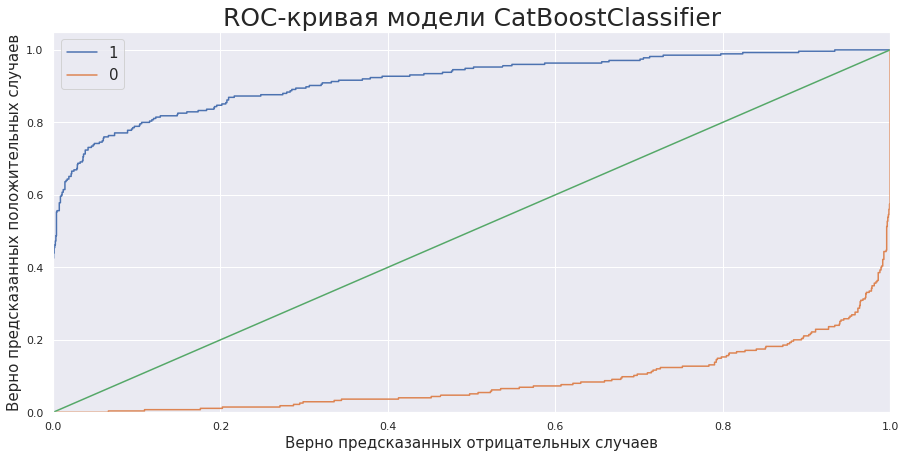

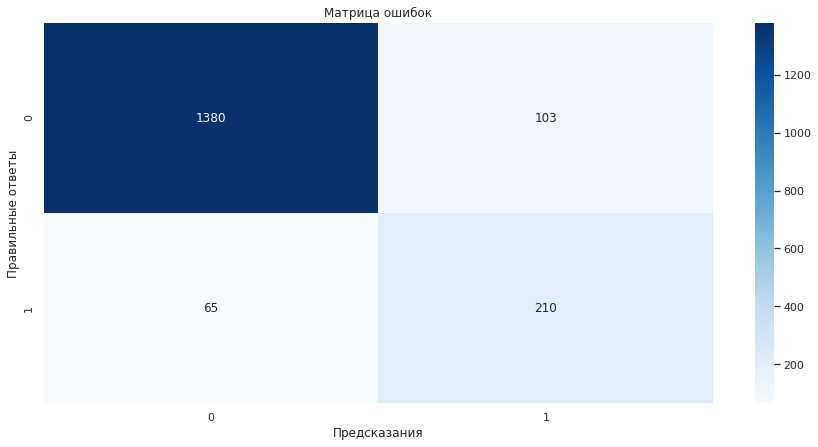

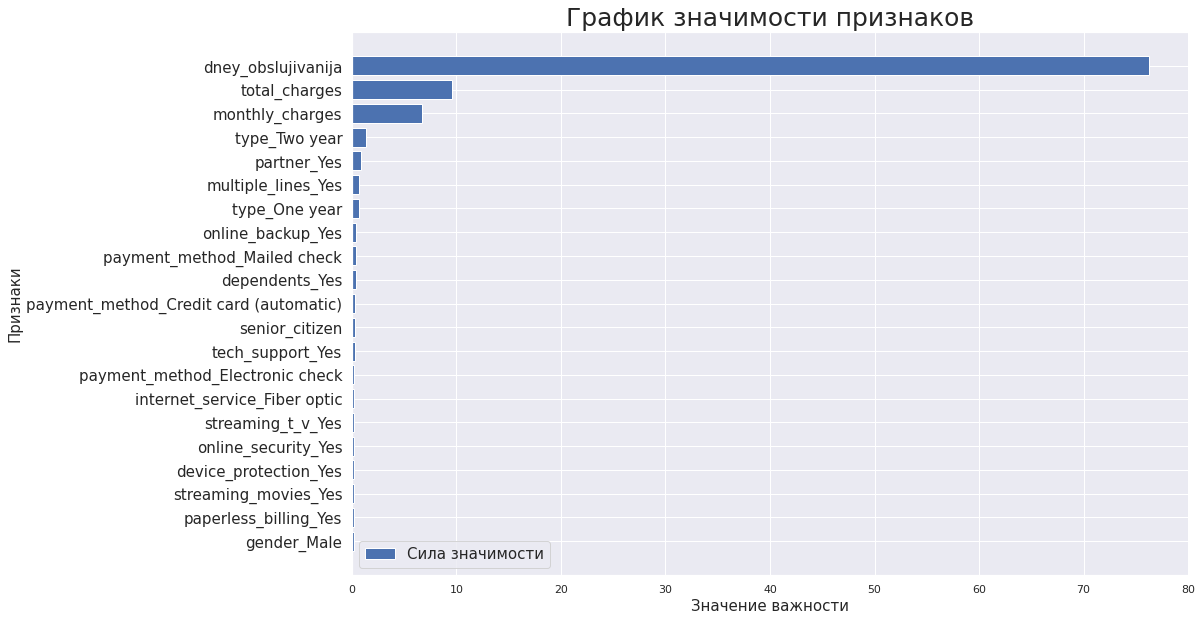

In [41]:
testing_model(features_test_ohe, target_test, grid_CatBoostClassifier)

In [214]:
# Предсказание на тестовых данных
predictions_test = grid_CatBoostClassifier.predict(features_test_ohe)

# Добавление нового результата
new_data = {'Модель':'CatBoostClassifier_test', 'roc_auc ':'{:.3}'.format(roc_auc_score(target_test, predictions_test)),
            'Модель':'CatBoostClassifier_test', 'accuracy':'{:.3}'.format(accuracy_score(target_test, predictions_test))}
result = result.append(new_data, ignore_index=True)
result

,Модель,roc_auc,accuracy,roc_auc
0,LogisticRegression_valid,0.758,NaN,NaN
1,RandomForestClassifier_valid,0.82,NaN,NaN
2,LGBMClassifier_valid,0.888,NaN,NaN
3,CatBoostClassifier_valid,0.914,NaN,NaN
4,CatBoostClassifier_test,NaN,0.908,0.851


     Модель CatBoostClassifier хорошо обучилась и прошла порог ROC-AUC = 0,85. 
     Хорошо придсказывает случаи где клиенты остаются чуть хуже где уходят. 
     Самые значимые признаки длительность обслуживания, общаяя сумма платежей, ежимесячный платеж, тип платижа прочие слабо зачимы на равне.

##  Общий вывод

### Подготовка данных

    Данные распознались ______________________________________________________ДА
    Названия столбцов в нижнем регистре ______________________________________НЕТ -------------(исправилю)
    Имеются значения с неправельным типом данных _____________________________ДА --------------(исправилю)
    Пропущеные значения ______________________________________________________НЕТ
    Откланения в уникальных значениях ________________________________________ДА --------------(исправилю)
    Дубликаты ________________________________________________________________НЕТ
    Имеются неважные(нерелевантные) столбцы(признаки) для МО _________________ДА --------------(исправилю)
    Имеются не отмасштабированые значения для МО _____________________________ДА --------------(исправилю)
    Имеются строковые категариальные признаки ________________________________ДА --------------(исправилю)
    Имеются сильно зависимые признаки для МО _________________________________НЕТ
    Отсутствуют целевые столбцы(признаки) для МО _____________________________НЕТ

### Исследование задачи

    Названия столбцов в нижнем регистре ______________________________________НЕТ -------------(исправил)
    Имеются значения с неправельным типом данных _____________________________ДА --------------(исправил)
    Пропущеные значения ______________________________________________________ДА --------------(исправил)
    Откланения в уникальных значениях ________________________________________ДА --------------(исправил)
    Дубликаты ________________________________________________________________ДА --------------(исправил)
    Имеются неважные(нерелевантные) столбцы(признаки) для МО _________________ДА --------------(исправилю)
    Имеются не отмасштабированые значения для МО _____________________________ДА --------------(исправилю)
    Имеются строковые категариальные признаки ________________________________ДА --------------(исправилю)
    Имеются сильно зависимые признаки для МО _________________________________ДА --------------(исправилю)
    Отсутствуют целевые столбцы(признаки) для МО _____________________________НЕТ

    Отток в зависимости от даты начала договора был высоким лишь в начале постепенно снижаясь, с 2017 года отток почти иссяк и начался заметный рост тех кто оставался
    
    Отток в зависимости от суммы ежемесячного платежа в группе дешевых тарифов не высок по отношению к оставшимся, среди средних тарифов минимален а среди дорогих не значителен по отношению к оставшимся но заметен, начиная со 100 уходит приблезительно половина от оставшихся сравниваясь к 120
    
    Отток в зависимости от общей суммы платежей к оставшимся не значителен до 2 тыс. после идет устойчивый отток и постепенное снижение оставшихся, с 4 тыс. снижается отток до минимальных значений стабилизируются оставшиеся до 6 тыс. после отток на уровне погрешности а оставшиеся медленно снижаются к 9 тыс.
    
    Отток от наличия супруга на половину больше чем от одиночек так же и осавшихся чуть меньше среди пар. Наверное связан с кономией среди пар
    
    Отток в зависимости от срока обслуживания по началу и мало к оставшимся с 500 дней начинается рост оттока и падение оставшихся после 1000 дней переодически сравниваются а иногда отток превышает оставшихся к 1500 дней идет восстановление а после падение оттока к 2000 дней до минимума и большой рост оставшихся после

    Распределение ежемесячных платежей не равномерное но явно выделяется дешевые самый многочисленные, средней стоимости  и дорогие тарифы

    Зависимость начала договора к типу платежа показывает что с 2013 года пользователи массово предпочитали оплачивать услуги за 2 года, за 1 год реже такие же показатели и у типа раз в месяц, но затем по истечении этих 2х лет с 2015 ситуация начинает менятся к 2020му за 2 года почти перестают платить как и за 1 год а за раз в месяц всё больше. Предпологаю так связано с условием подключения и началу работы данного оператора.
    
    Зависимость начала договора к общей суммой платежей показывает что только с 2019 года начинается сильный прирост пользователей и снижение оттока.
    
    Зависимость начала договора к сроку обслуживания показывает что только со 2й половины 2019 года сильный прирост новых пользователей.
    
    Зависимость общей суммы платежей к ежемесячной показывает высокое значение дешовых тарифов и резкое снижение к дорогим.
    
    Зависимость ежемесячной суммы платежей к типу провода высокое значение дешовых тарифов к обоим типам но оптика в приоритете, среди средних тарифов для оптики таких нет для ДСЛ есть а для дорогих наоборот.
    
    Зависимость общей суммы платежей к сроку обслуживания показывает резкий прирост новых пользователей.
    
    Зависимость семейных к иждевенцам показывает большое значение среди одиноких без иждевенцев, почти равное среднее значение среди семейных с иждевенцом и без, и минимальное среди одиноких с иждевенцом.

### Подготовка данных для МО

    Названия столбцов в нижнем регистре ______________________________________НЕТ -------------(исправил)
    Имеются значения с неправельным типом данных _____________________________ДА --------------(исправил)
    Пропущеные значения ______________________________________________________ДА --------------(исправил)
    Откланения в уникальных значениях ________________________________________ДА --------------(исправил)
    Дубликаты ________________________________________________________________ДА --------------(исправил)
    Имеются неважные(нерелевантные) столбцы(признаки) для МО _________________ДА --------------(исправил)
    Имеются не отмасштабированые значения для МО _____________________________ДА --------------(учел)
    Имеются строковые категариальные признаки ________________________________ДА --------------(исправил)
    Имеются сильно зависимые признаки для МО _________________________________ДА --------------(учел)
    Отсутствуют целевые столбцы(признаки) для МО _____________________________НЕТ

 Не масштабировал и не избавлялся от сильно зависимых признаков и не балансировал классы т.к. выбранные модели не чувствительные к этому кроме LogisticRegression для неё добавил масштабирование в Pipeline, а для балансировки использую параметр внутри моделей class_weight='balanced'.

### Обучение модели и подбор гипер параметров

                          Модель	     roc_auc     accuracy  roc_auc
    0	LogisticRegression_valid	      0.758	    NaN	 NaN
    1	RandomForestClassifier_valid	   0.82	    NaN     NaN
    2	LGBMClassifier_valid	          0.888	    NaN     NaN
    3	CatBoostClassifier_valid	      0.914	    NaN	 NaN
    4	CatBoostClassifier_test	         NaN	   0.908   0.851

     Модель CatBoostClassifier хорошо обучилась и прошла порог ROC-AUC = 0,85. 
     Хорошо придсказывает случаи где клиенты остаются чуть хуже где уходят. 
     Самые значимые признаки длительность обслуживания, общаяя сумма платежей, ежимесячный платеж, тип платижа прочие слабо зачимы на равне.

### Итог

Цель достигнута удалось предсказать ситуацию когда клиент расторгнет договор с высокой вероятностью а когда нет, на основе модели со значением метрики качества AUC-ROC не меньше 0.85

##  Отчет

Целью исследования было создать модель, которая на основании имеющихся даннных будет предсказывать уход клиента. Целевой метрикой оценки точности предсказания модели считатется AUC-ROC с пороговым значением не нже 0,85.

Изначально план работы предполагал следующие действия:

1. Подготовить данные:
        Объеденение таблиц в одну
        Исправление типов данных
        Создание целевого признака
        Создание столбца с количеством лет обслуживания
    
    Повторный анализ данных(объедененных данных):
        Проверить пропуски
        Проверить дубликаты
        и прочее как на предварительном анализе
        устранить выявленные недочеты
          
2. Провести исследовательский анализ данных:
        Сравнить группы клиентов ушедших и оставшихся
        Сравнить распределение ежемесячных платежей
        Проверить наличие иждевенцев на факт оттока
    
3. Подготовка данных для МО:
        Удаление лишних признаков
        Разделение на выборки
        Избавление от строковых категариальных признаков
    
4. Построить и обучить модель с перебором гипер параметров:
        LogisticRegression
        RandomForestClassifier
        CatBoostClassifier
        LightGBMClassifier
        Проверить на тестовой выборке
    
5. Общий вывод:
        Вывод по каждому разделеу
    
6. Отчет.
_________________________
    В целом все этапы были выполнены согласно данного плана. Из затруднений в ходе работы хочу отметить, что тяжело было добится более высокой метрики в модели LGBMClassifier свези с тем что слишком долго считала по матрице подбора параметров.
    
    Ключевыми этапами работы можно выделить предварительную обработку данных, анализ данных и подбор гиперпараметров с помощью Pipeline и GridSearchCV.
    
    Важные технические детали:
    
    RANDOM_STATE = 170723, информация о договорах актуальна на 1 февраля 2020.
        Подготовил данные путем слияния таблиц методом merge how='left', привел названия столбцов к нжнему регистру собственной функцией, создал целевой признак ottok и признак dney_obslujivanija, заполненил пропуски методом ffill и bfill значениями верхней и нжней строки.
        Проанализировал сравнив группы клиентов ушедших и оставшихся по отношению к целевому признаку собственной функцией, сравнил распределение ежемесячных платежей, сравнил самые зависимые признаки по результатам карреляции собственной функцией.
        Подготовил данные для МО удалил лишние признаки begin_date и end_date, разделил на выборки по параметрам  test_size=0.25 и stratify=target, избавился от строковых категариальных признаков методом OneHotEncoder. 
        Не масштабировал и не избавлялся от сильно зависимых признаков и не балансировал классы т.к. выбранные модели не чувствительные к этому кроме LogisticRegression для неё добавил масштабирование в Pipeline, а для балансировки использую параметр внутри моделей class_weight='balanced'.
        Обученил модели LogisticRegression, RandomForestClassifier, CatBoostClassifier, LightGBMClassifier и подборал гипер параметры методом Pipeline и GridSearchCV. 
        Протестировал самую лучшую модель CatBoostClassifier 
    
    на данном наборе признаков:
        payment_method_Credit card (automatic)	total_charges	monthly_charges	payment_method_Mailed check	multiple_lines_Yes	internet_service_Fiber optic	type_One year	payment_method_Electronic check	paperless_billing_Yes	online_security_Yes	streaming_movies_Yes	senior_citizen	streaming_t_v_Yes	gender_Male	dependents_Yes	tech_support_Yes	partner_Yes	dney_obslujivanija	device_protection_Yes	online_backup_Yes	type_Two year 
    
    и параметрами {'model__depth': 2, 'model__l2_leaf_reg': 0.9, 'model__learning_rate': 0.3, 'model__n_estimators': 1500} 
    
    со значением AUC-ROC=0.914 на тренировачной выборке котороя позволила достичь заявленной цели со значением AUC-ROC=0.851 и Аccuracy=0.908 на тестовой, провел анализ обученной модели собственной функцией.